In [44]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import scanpy as sc
#import omicverse as ov
from gprofiler import GProfiler

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python"
os.chdir(myDir)
import ProxseqClasses as PC
import calculateweightedPPI as WPPI
import ProxseqFunctions as PF

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [54]:
save_dir = '/Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/'

In [3]:
adata = sc.read_h5ad('GPS/20250521/adata_recluster_annotated.h5ad')

In [46]:
#raw count data
ctrl_data = pd.read_csv('GPS/20250521/Ctrl_count_matrix.txt.gz',sep="\t",index_col=0)
cona_data = pd.read_csv('GPS/20250521/ConA_count_matrix.txt.gz',sep="\t",index_col=0)

In [47]:
# Calculate downsampling ratio
downsample_ratio =  23264483 / 36506695 # ≈ 0.637

# Define function to downsample each count value
def downsample_df(df, ratio):
    return df.applymap(lambda x: np.random.binomial(n=int(x), p=ratio) if x > 0 else 0)

# Downsample ctrl_target to match ConA depth
ctrl_data_downsampled = downsample_df(ctrl_data, downsample_ratio)

/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_30518/2028900832.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: np.random.binomial(n=int(x), p=ratio) if x > 0 else 0)


In [6]:
all_protein_list = [
    "CD45", "CD47", "CD48", "CD44", "CD2", "CD3", "CD4", "CD8", "CD5", "CD7",
    "CD27", "CD45RA", "CD45RO", "CD62L", "CCR5", "CCR7", "CD127", "CD25", "CD28",
    "CD137", "CD154", "CD150", "CD38", "PD1", "TIM-3", "LAG-3", "CTLA-4",
    "CD19", "CD20", "CD56", "CD16", "CD14", "CD11b", "CD11c", "HLADR", "CXCR3",
    "CXCR4", "CD11a", "CD49e", "CD29", "ICAM-1", "CD81", "CD147", "free_oligo"]

all_lectin_list = [
    "PHA-L", "PHA-E", "DSL", "ConA", "PNA", "MAL-I", "MAL-II", "SNA", "DBA",
    "ECA", "AAL", "LEL", "GSL-II", "Galectin-3", "UEA-I", "free_oligo"]

In [7]:
# Construct the full index list
index_list = [f'{protein}:{lectin}' for protein in all_protein_list for lectin in all_lectin_list]

# Reindex both datasets to ensure all indices exist, fill missing with 0
ctrl_target = ctrl_data_downsampled.reindex(index_list).fillna(0)
cona_target = cona_data.reindex(index_list).fillna(0)

# Remove the 'free_oligo:free_oligo' row if present
ctrl_target = ctrl_target.loc[~ctrl_target.index.str.contains('free_oligo:free_oligo')]
cona_target = cona_target.loc[~cona_target.index.str.contains('free_oligo:free_oligo')]

In [8]:
ctrl_pla = PC.plaObject(ctrl_target)
ctrl_pla.calculateProteinCount()

cona_pla = PC.plaObject(cona_target)
cona_pla.calculateProteinCount()

In [9]:
my_protein = [
    "CD45", "CD47", "CD48", "CD44", "CD2", "CD3", "CD4", "CD8", "CD5", "CD7",
    "CD27", "CD45RA", "CD45RO", "CD62L", "CCR5", "CCR7", "CD127", "CD25", "CD28",
    "CD137", "CD154", "CD150", "CD38", "PD1", "TIM-3", "LAG-3", "CTLA-4",
    "CD19", "CD20", "CD56", "CD16", "CD14", "CD11b", "CD11c", "HLADR", "CXCR3",
    "CXCR4", "CD11a", "CD49e", "CD29", "ICAM-1", "CD81", "CD147"]
my_lectin = ["PHA-L", "PHA-E", "DSL", "ConA", "PNA", "MAL-I", "MAL-II", "SNA", "DBA",
    "ECA", "AAL", "LEL", "GSL-II", "Galectin-3", "UEA-I"]
ctrl_protein = ctrl_pla.protein_count.loc[my_protein,:]
ctrl_lectin = ctrl_pla.protein_count.loc[my_lectin,:]

cona_protein = cona_pla.protein_count.loc[my_protein,:]
cona_lectin = cona_pla.protein_count.loc[my_lectin,:]

In [10]:
# Define the CLR normalization function adapted from Seurat
def clr_function(column):
    # Filter out zeros for log transformation and only include positive values
    positive_values = column[column > 0]
    
    # Calculate the mean of log-transformed positive values
    mean_log = np.sum(np.log1p(positive_values)) / len(column)
    
    # Normalize by subtracting the exponential mean from each log-transformed value
    clr_values = np.log1p(column / np.exp(mean_log))
    
    return clr_values

In [11]:
#clr normalization
ctrl_clr_protein = ctrl_protein.apply(clr_function,axis=0)
ctrl_clr_lectin = ctrl_lectin.apply(clr_function,axis=0)

cona_clr_protein = cona_protein.apply(clr_function,axis=0)
cona_clr_lectin = cona_lectin.apply(clr_function,axis=0)

PCA and UMAP based on protein features

In [12]:
# Merge the two protein datasets (proteins x cells → combined)
clr_protein_all = pd.concat([ctrl_clr_protein, cona_clr_protein], axis=1)
clr_protein_all = clr_protein_all.T
common_cells = clr_protein_all.index.intersection(adata.obs_names)
clr_protein_all = clr_protein_all.loc[common_cells]
adata = adata[common_cells].copy()
adata_protein = sc.AnnData(clr_protein_all)
# Identify duplicated obs_names
duplicates = adata_protein.obs_names.duplicated(keep='first')

# Keep only unique entries
adata_protein = adata_protein[~duplicates].copy()

adata_protein.obs = adata.obs.copy()

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [48]:
# Define mapping from fine to coarse cell type labels
annotation_map = {
    "CD4+ Naive T cells": "CD4 T cells",
    "CD4+ Central Memory": "CD4 T cells",
    "CD4+ Effector Memory": "CD4 T cells",
    
    "CD8+ Naive T cells": "CD8 T cells",
    "CD8+ Central Memory": "CD8 T cells",
    "CD8+ Effector Memory": "CD8 T cells",
    "CD8+ Effector Memory RA": "CD8 T cells",

    "NK cells_CD56+CD16+": "NK cells",
    "NK cells_CD56+CD16-": "NK cells",
    "NK T cells": "NK T cells",
    
    "B cells": "B cells",
    "Dendritic Cells": "Dendritic cells",
    "Monocytes": "Monocytes",
    
    "Treg": "CD4 T cells",  # often grouped under CD4 lineage
    "Other": "Other"
}

# Create new column based on mapping
adata_protein.obs['main_annotation'] = adata_protein.obs['manual_annotation_reclustered'].map(annotation_map).fillna("Other").astype("category")

In [49]:
adt_marker_dict = {
    "B cells": ["CD19", "CD20"], 
    "CD4 T cells": ["CD3","CD4"],
    "CD8 T cells": ["CD3","CD8"],
    "Dendritic cells": ["HLADR"],
    "Monocytes": ["CD14", "CD11b"],
    "NK T cells": ["CD3", "CD56"],
    "NK cells": ["CD56", "CD16"]
}

In [50]:
# Subset only cells with condition == 'control'
adata_adt_control = adata_protein[(adata_protein.obs["condition"] == "control") & (adata_protein.obs["main_annotation"] != "Other")].copy()

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


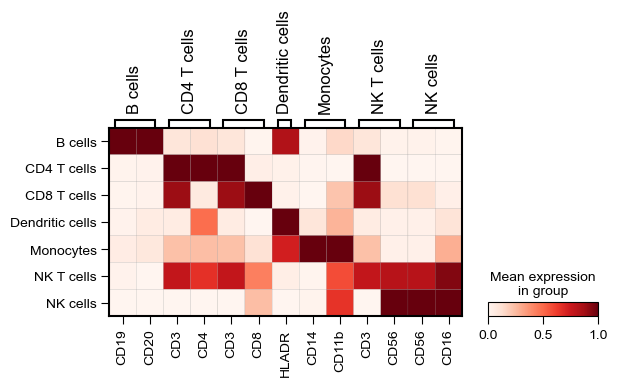

In [56]:
# Plot matrixplot only for control cells
sc.pl.matrixplot(
    adata_adt_control,
    adt_marker_dict,
    groupby="main_annotation",
    standard_scale='var',
    cmap='Reds',
    show=False
)
plt.savefig(save_dir+'de_adt_matrixplot.svg', format='svg', bbox_inches='tight',pad_inches=0)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


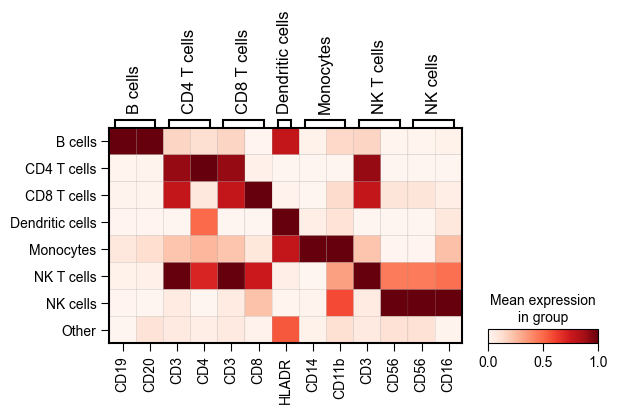

In [208]:
sc.pl.matrixplot(adata_protein, adt_marker_dict, groupby="main_annotation_reclustered", standard_scale='var', cmap='Reds', show=True)
#plt.savefig(
#    save_dir+'de_adt_matrixplot.svg',
#    format='svg',
#    bbox_inches='tight',
#    pad_inches=0.5
#)

In [ ]:
# Flatten and deduplicate all markers from the original dict
unique_markers = ['CD19', 'CD20','CD3','CD4','CD8','HLADR','CD14','CD11c','CD56','CD16']

# Plot directly
sc.pl.matrixplot(
    adata_protein,
    var_names=unique_markers,
    groupby="main_annotation",
    standard_scale='var',
    cmap='Reds'
)

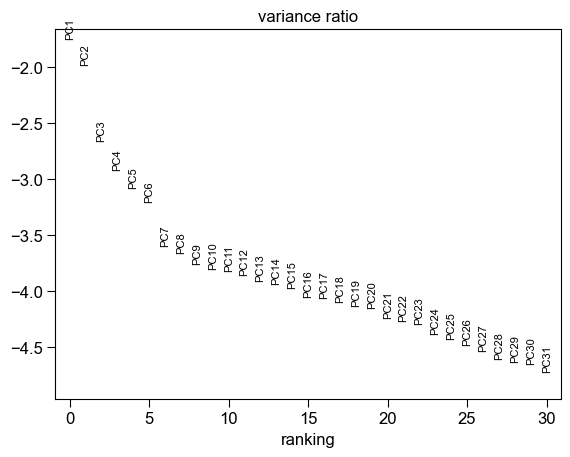

In [37]:
sc.pp.scale(adata_protein)
sc.tl.pca(adata_protein, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_protein, log=True)

In [38]:
sc.pp.neighbors(adata_protein, n_pcs=9)
sc.tl.umap(adata_protein)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


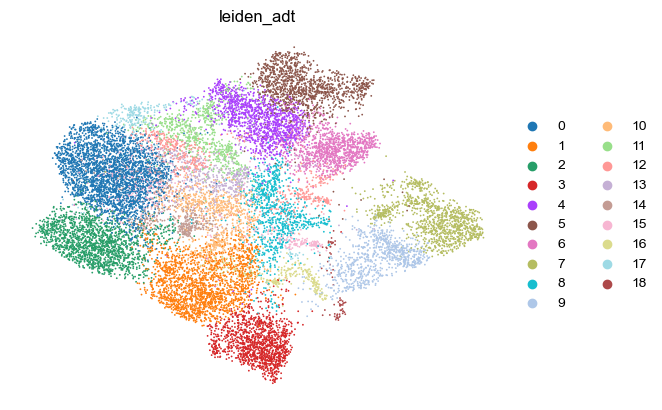

In [39]:
sc.tl.leiden(adata_protein, resolution = 1,key_added='leiden_adt') # resolution is customly chosen
sc.pl.umap(adata_protein, color=['leiden_adt'],frameon=False, legend_fontweight='normal', legend_fontsize=10)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


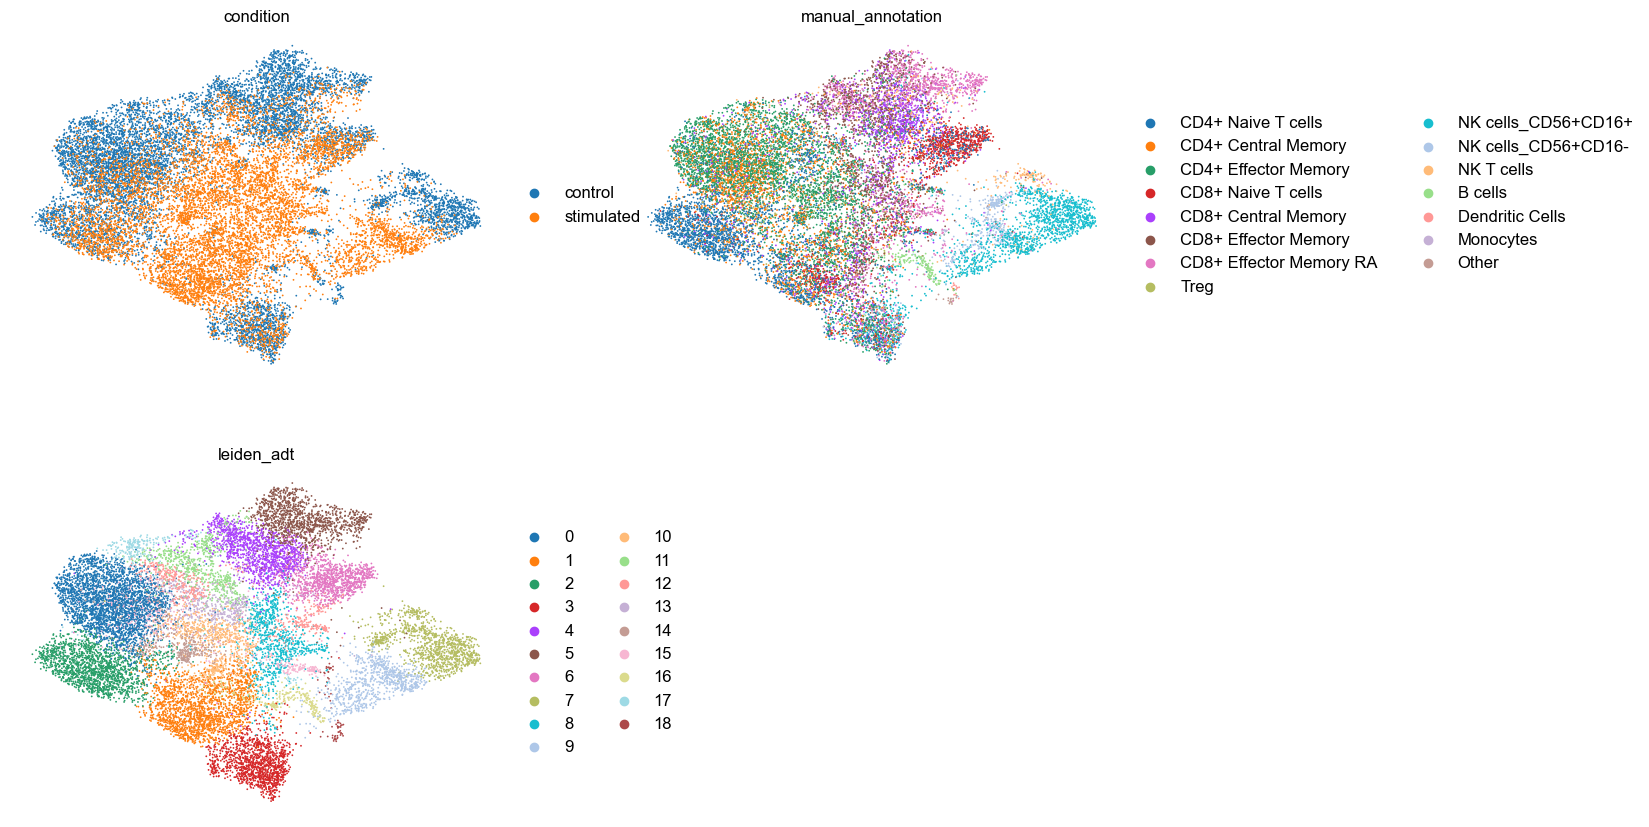

In [42]:
sc.pl.umap(adata_protein, color=["condition", "manual_annotation", 'leiden_adt'], ncols=2, frameon=False)  # change to your protein names

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning

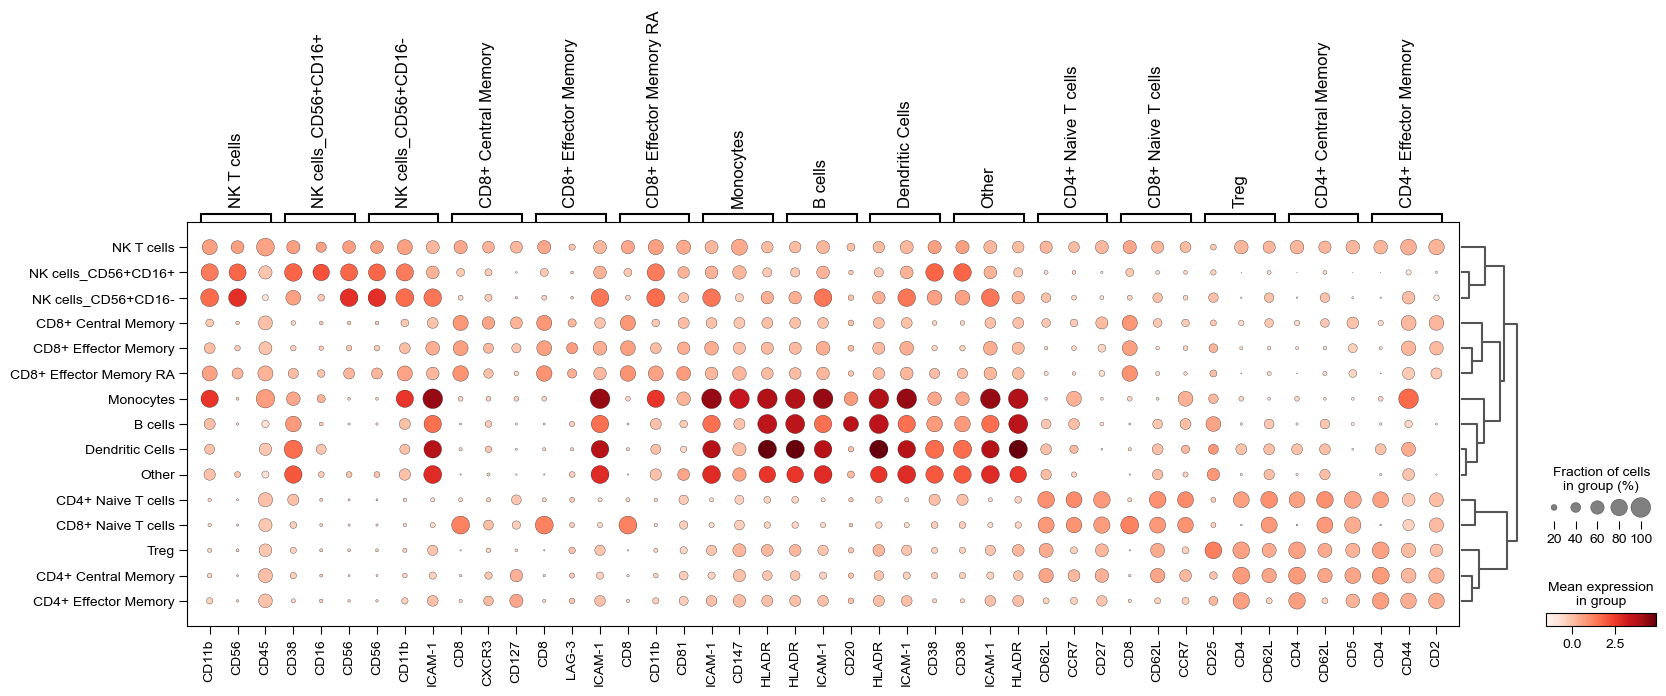

In [121]:
sc.tl.rank_genes_groups(adata_protein, groupby='manual_annotation', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_protein, n_genes=3)

PCA and UMAP based on glycan features

In [13]:
# Merge the two protein datasets (proteins x cells → combined)
clr_lectin_all = pd.concat([ctrl_clr_lectin, cona_clr_lectin], axis=1)
clr_lectin_all = clr_lectin_all.T
clr_lectin_all = clr_lectin_all.loc[common_cells]

adata_ldt = sc.AnnData(clr_lectin_all)
# Identify duplicated obs_names
duplicates = adata_ldt.obs_names.duplicated(keep='first')

# Keep only unique entries
adata_ldt = adata_ldt[~duplicates].copy()

adata_ldt.obs = adata.obs.copy()

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [179]:
# Define mapping from fine to coarse cell type labels
annotation_map = {
    "CD4+ Naive T cells": "CD4 T cells",
    "CD4+ Central Memory": "CD4 T cells",
    "CD4+ Effector Memory": "CD4 T cells",
    
    "CD8+ Naive T cells": "CD8 T cells",
    "CD8+ Central Memory": "CD8 T cells",
    "CD8+ Effector Memory": "CD8 T cells",
    "CD8+ Effector Memory RA": "CD8 T cells",

    "NK cells_CD56+CD16+": "NK cells",
    "NK cells_CD56+CD16-": "NK cells",
    "NK T cells": "NK T cells",
    
    "B cells": "B cells",
    "Dendritic Cells": "Dendritic cells",
    "Monocytes": "Monocytes",
    
    "Treg": "CD4 T cells",  # often grouped under CD4 lineage
    "Other": "Other"
}

# Create new column based on mapping
adata_ldt.obs['main_annotation'] = adata_ldt.obs['manual_annotation'].map(annotation_map).fillna("Other").astype("category")

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


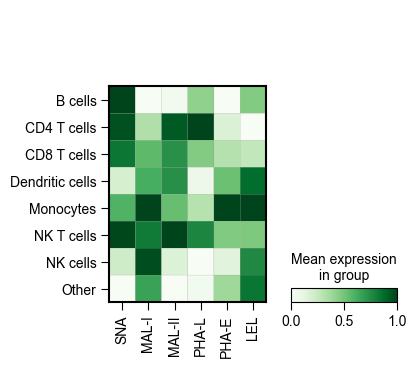

In [180]:
# Flatten and deduplicate all markers from the original dict
unique_lectin = ['SNA', 'MAL-I', 'MAL-II', 'PHA-L','PHA-E','LEL']

# Plot directly
sc.pl.matrixplot(
    adata_ldt,
    var_names=unique_lectin,
    groupby="main_annotation",
    standard_scale='var',
    cmap='Greens'
)

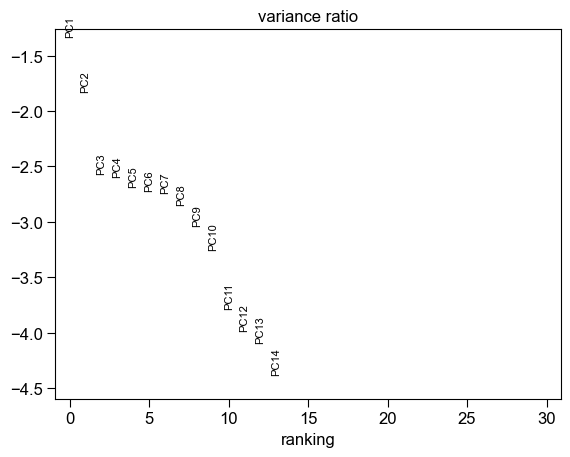

In [55]:
sc.pp.scale(adata_ldt)
sc.tl.pca(adata_ldt, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_ldt, log=True)

In [56]:
sc.pp.neighbors(adata_ldt, n_pcs=5)
sc.tl.umap(adata_ldt)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


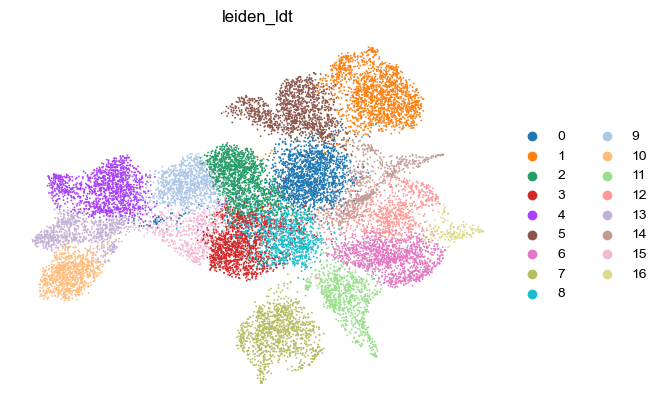

In [57]:
sc.tl.leiden(adata_ldt, resolution = 1,key_added='leiden_ldt') # resolution is customly chosen
sc.pl.umap(adata_ldt, color=['leiden_ldt'],frameon=False, legend_fontweight='normal', legend_fontsize=10)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


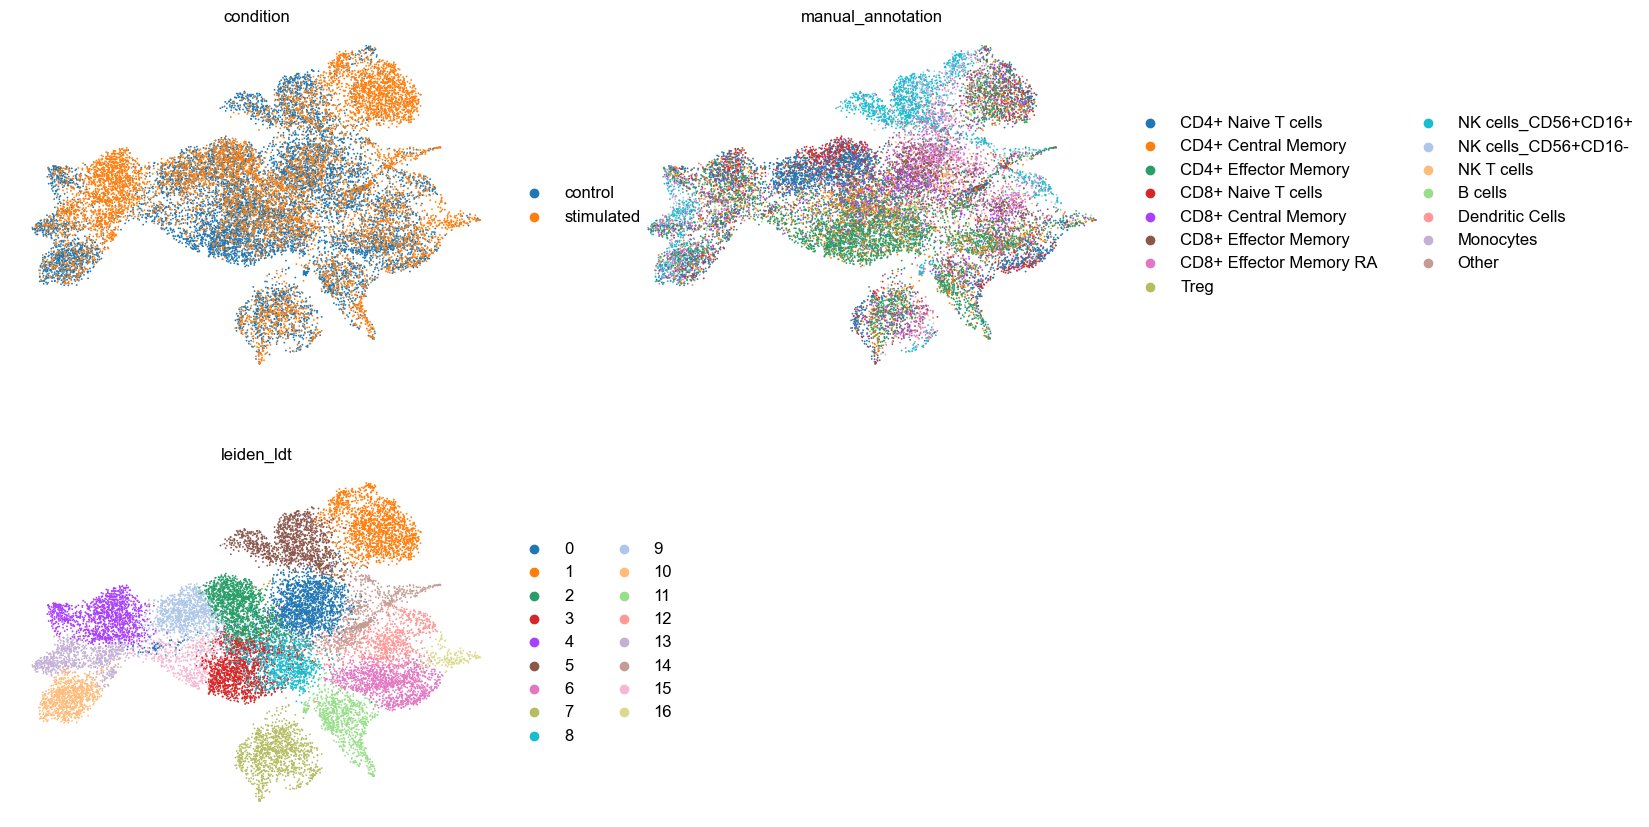

In [58]:
sc.pl.umap(adata_ldt, color=["condition", "manual_annotation", 'leiden_ldt'], ncols=2, frameon=False)  # change to your protein names

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning

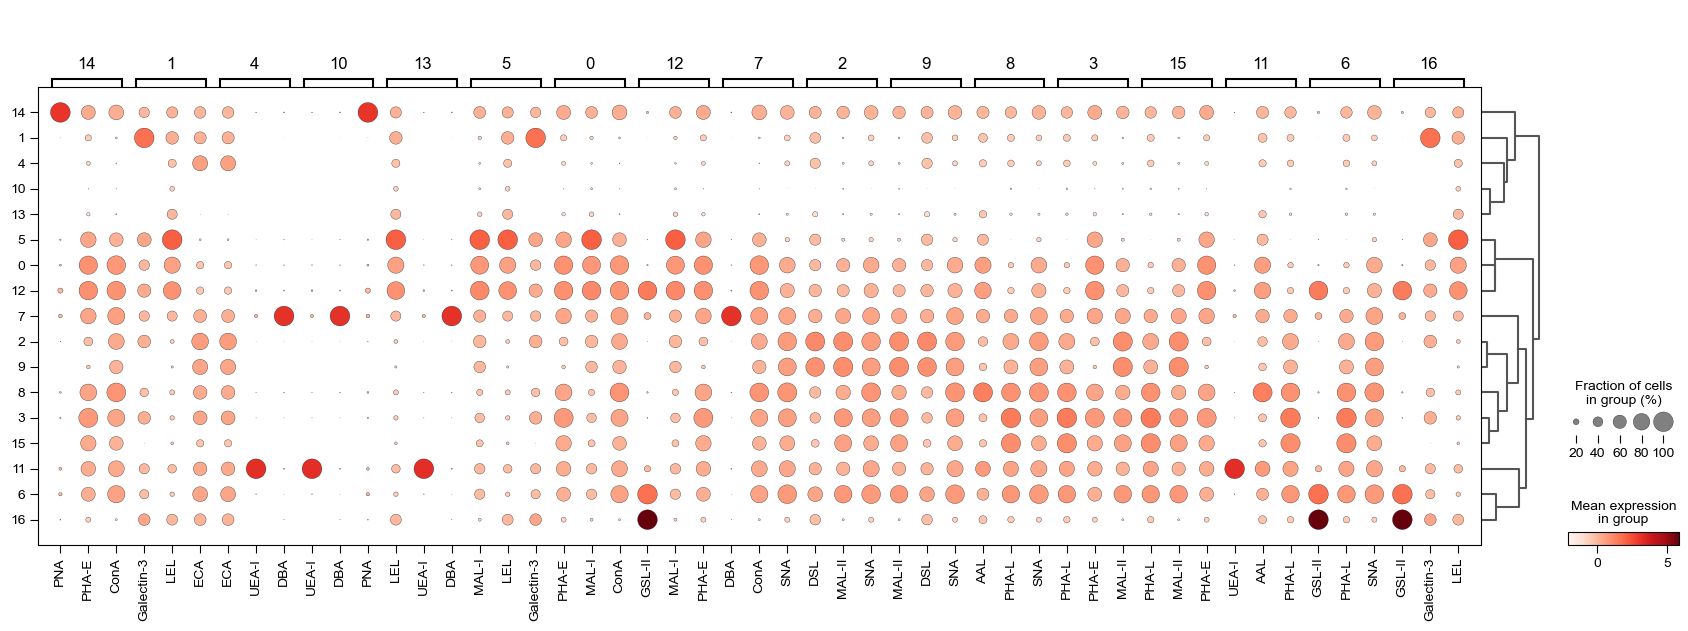

In [61]:
sc.tl.rank_genes_groups(adata_ldt, groupby='leiden_ldt', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_ldt, n_genes=3)

protein abundance change between conditions in different cell subtypes

In [14]:
# Assign to adata
clr_protein_all = clr_protein_all[~clr_protein_all.index.duplicated(keep='first')]
adata.obsm["protein"] = clr_protein_all

In [15]:
for protein in adata.obsm["protein"].columns:
    new_key = f"ADT_{protein}"
    # Add to .obs with the prefixed name
    adata.obs[new_key] = adata.obsm["protein"][protein]

In [18]:
# Define mapping from fine to coarse cell type labels
annotation_map = {
    "CD4+ Naive T cells": "CD4 T cells",
    "CD4+ Central Memory": "CD4 T cells",
    "CD4+ Effector Memory": "CD4 T cells",
    
    "CD8+ Naive T cells": "CD8 T cells",
    "CD8+ Central Memory": "CD8 T cells",
    "CD8+ Effector Memory": "CD8 T cells",
    "CD8+ Effector Memory RA": "CD8 T cells",

    "NK cells_CD56+CD16+": "NK cells",
    "NK cells_CD56+CD16-": "NK cells",
    "NK T cells": "NK T cells",
    
    "B cells": "B cells",
    "Dendritic Cells": "Dendritic cells",
    "Monocytes": "Monocytes",
    
    "Treg": "CD4 T cells",  # often grouped under CD4 lineage
    "Other": "Other"
}

# Create new column based on mapping
adata.obs['main_annotation'] = adata.obs['manual_annotation_reclustered'].map(annotation_map).fillna("Other").astype("category")

In [111]:
mrna_marker_dict = {
    "CD4+ Naive": ["CCR7", "SELL", "TCF7", "LEF1"],
    "CD4+ TCM": ["IL7R","SELL", "TCF7", "LEF1"],
    "CD4+ TEM": ["IL7R", "ITGB1"],
    "CD8+ Naive T cells": ['CD8A',"CCR7", "TCF7", "LEF1"],
    "CD8+ TCM": ["CD8A", "IL7R"],
    "CD8+ TEM": ["CD8A", "IL7R", "GZMB", "GZMK", "PRF1", 'NKG7','GNLY'],
    "CD8+ TEMRA": ["CD8A", "GZMB", "PRF1", "KLRG1", "SELL"],
    "Treg" : ['FOXP3'],
    "NK CD56+CD16+": ["NCAM1", "FCGR3A", "PRF1", "GZMB", "KLRD1", "NKG7"],
    "NK CD56+CD16-": ["NCAM1", "XCL1", "XCL2", "GNLY", "GZMK"],
    "NKT" : ['CD3D', 'CD8A', 'NCAM1'],
    "B cell" : ['CD79A', 'MS4A1'],
    "Monocytes": ["CD14", "LYZ", "S100A8", "S100A9"],
    "DC": ["LAMP3", 'CD74', 'HLA-DPA1'],
}

In [57]:
# Define shared cytotoxic genes separately
cytotoxic_markers = ["PRF1", "GZMB", "NKG7", "GNLY"]

mrna_marker_dict_refined = {
    "Naive T": ["CCR7", "SELL", "TCF7", "LEF1"],
    "Memory T": ["IL7R", "ITGB1"],
    "Regulatory T": ["FOXP3"],
    "Cytotoxic Module": cytotoxic_markers,  # appear once
    "NK": ["NCAM1", "FCGR3A", "KLRD1"],  # exclude repeated cytotoxic markers
    "NKT": ["CD3D","NCAM1"],             # also avoid overlap
    "B": ["MS4A1", "CD79A"],
    "Monocytes": ["CD14", "LYZ", "S100A8", "S100A9"],
    "DCs": ["LAMP3", "CD74", "HLA-DPA1"]
}

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' 

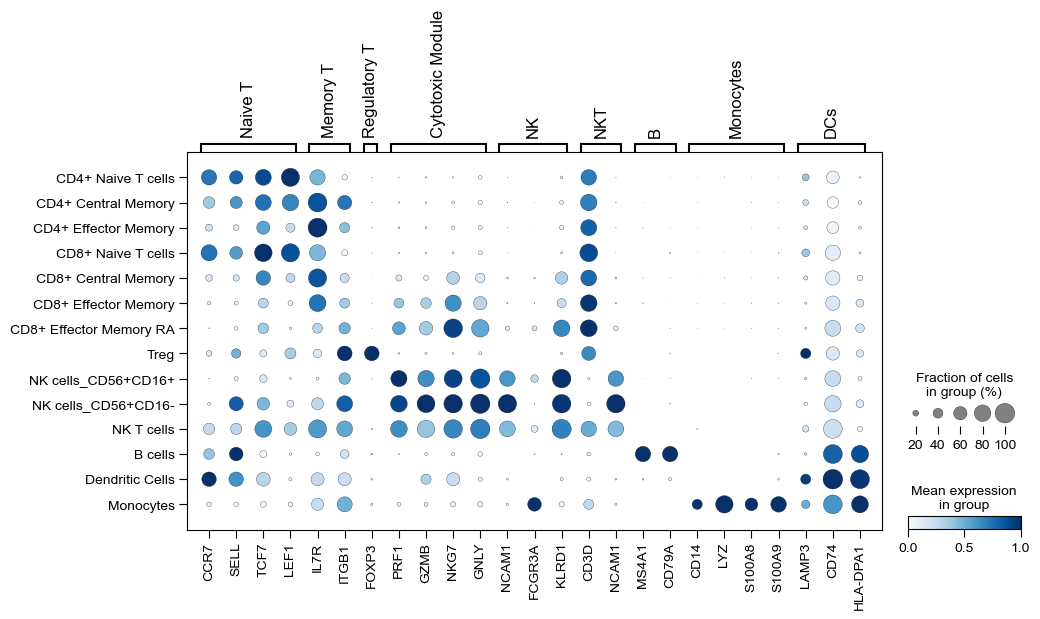

In [60]:
sc.pl.dotplot(adata_control, mrna_marker_dict_refined, groupby="manual_annotation_reclustered", standard_scale='var', cmap='Blues',show=False)
plt.savefig(save_dir+'de_mrna_dotplot.svg', format='svg', bbox_inches='tight',pad_inches=0)

In [ ]:
with plt.rc_context({'figure.figsize':(3,3),
                 'font.family':'Arial',
                 'font.size':12,
                 'figure.dpi':300}):
    fig = sc.pl.umap(adata, color=['manual_annotation'],
                     add_outline=True, alpha=1,
                     outline_color = ('black', None),
                     frameon=False,
                     size=0.5)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

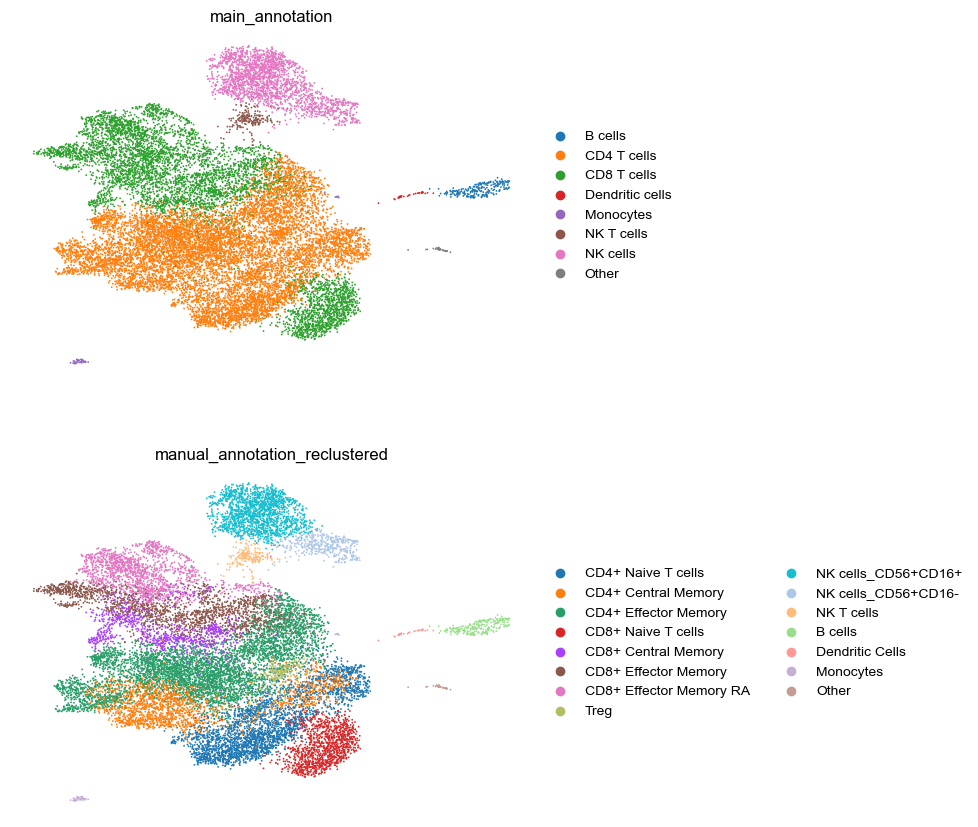

In [61]:
sc.pl.umap(adata, color=['main_annotation','manual_annotation_reclustered',],ncols=1,frameon=False, legend_fontweight='normal', legend_fontsize=10)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


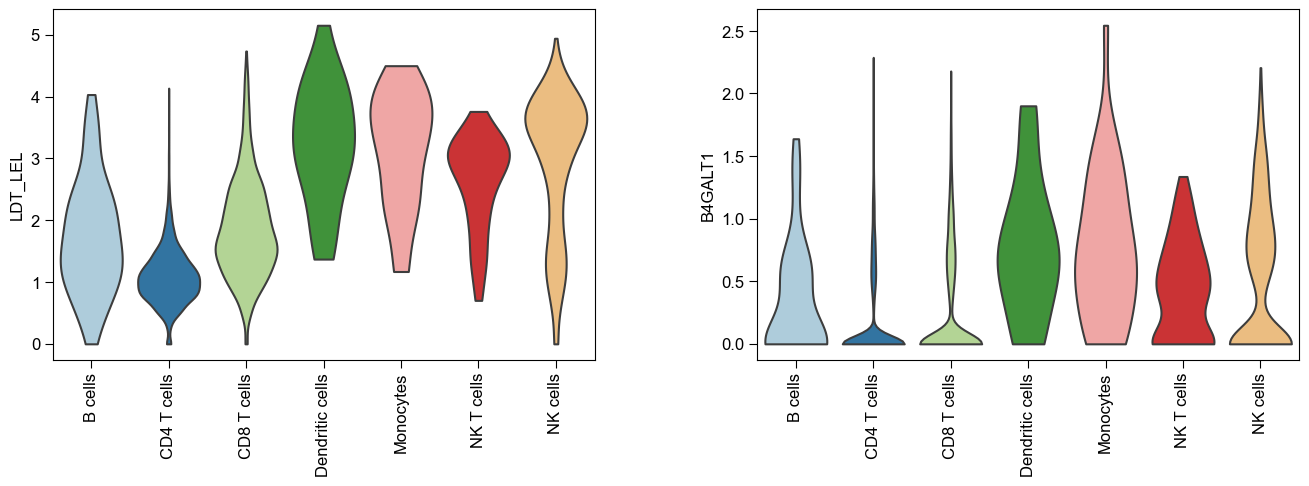

In [62]:
# Subset to control condition only
adata_control = adata[
    (adata.obs["condition"] == "control") & 
    (adata.obs["main_annotation"] != "Other")
].copy()

sc.pl.violin(
    adata_control,
    keys=['LDT_LEL', 'B4GALT1'],
    groupby="main_annotation",
    stripplot=False,
    rotation=90,
    palette='Paired',
    multi_panel=True,
    ncols=2,
    show=False
)

In [13]:
# Merge the two protein datasets (proteins x cells → combined)
clr_protein_all = pd.concat([ctrl_clr_protein, cona_clr_protein], axis=1)
clr_protein_all = clr_protein_all.T
common_cells = clr_protein_all.index.intersection(adata.obs_names)
clr_protein_all = clr_protein_all.loc[common_cells]
adata = adata[common_cells].copy()

In [14]:
# Assign to adata
clr_protein_all = clr_protein_all[~clr_protein_all.index.duplicated(keep='first')]
adata.obsm["protein"] = clr_protein_all

In [15]:
for protein in adata.obsm["protein"].columns:
    new_key = f"ADT_{protein}"
    # Add to .obs with the prefixed name
    adata.obs[new_key] = adata.obsm["protein"][protein]

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from matplotlib.colors import TwoSlopeNorm

def high_mode_mean(values):
    """Return mean of the higher component in a 2-component GMM."""
    values = np.array(values).reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0).fit(values)
    means = gmm.means_.flatten()
    return max(means)

def plot_per_celltype_heatmaps_scaled(
    adata,
    feature_prefix="ADT_",
    celltypes=None,
    groupby="manual_annotation",
    condition_col="condition",
    figsize=(2.5, 6),
    cmap="vlag",
    save_dir=None,
    scale="zscore"  # or "center", "robust", or None
):
    """
    Per-cell type heatmap of LDT features (e.g., lectin/protein binding), scaled across conditions.
    
    If proteins like CD44 or CD45 show bimodal distribution, this function uses
    a GMM to extract the high-expression mode mean for the stimulated condition.
    """

    # Make save directory if needed
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # Step 1: detect features
    feature_cols = [col for col in adata.obs.columns if col.startswith(feature_prefix)]

    # Step 2: get all relevant cell types
    if celltypes is None:
        celltypes = adata.obs[groupby].unique().tolist()

    # Step 3: define bimodal proteins (adjust names as needed)
    special_proteins = [f"{feature_prefix}CD44", f"{feature_prefix}CD45"]

    for celltype in celltypes:
        adata_subset = adata[adata.obs[groupby] == celltype]
        if adata_subset.n_obs == 0:
            continue

        # Step 4: compute summary (median or high-mode for bimodal in stimulated)
        rows = []
        for condition in adata_subset.obs[condition_col].unique():
            subset = adata_subset.obs[adata_subset.obs[condition_col] == condition]
            row = {}
            for col in feature_cols:
                if condition.lower() == "stimulated" and col in special_proteins:
                    try:
                        row[col] = high_mode_mean(subset[col])
                    except:
                        row[col] = np.nan
                else:
                    row[col] = subset[col].median()
            rows.append(pd.Series(row, name=condition))
        df = pd.DataFrame(rows).T

        # Step 5: scale across conditions (row-wise)
        if scale == "zscore":
            df_scaled = df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
        elif scale == "center":
            df_scaled = df.sub(df.mean(axis=1), axis=0)
        elif scale == "robust":
            df_scaled = df.apply(lambda x: (x - x.median()) / (x.quantile(0.75) - x.quantile(0.25)), axis=1)
        else:
            df_scaled = df

        # Step 6: plot
        plt.figure(figsize=figsize)
        norm = TwoSlopeNorm(vcenter=0)
        sns.heatmap(df_scaled, cmap=cmap, norm=norm, cbar=True, fmt=".2f")

        plt.title(celltype)
        plt.xticks(rotation=90, ha='center')
        plt.ylabel("Protein")
        plt.tight_layout()

        # Save or show
        if save_dir:
            filename = os.path.join(save_dir, f"{celltype.replace(' ', '_')}_protein_change.pdf")
            plt.savefig(filename)
            plt.close()
            print(f"Saved: {filename}")
        else:
            plt.show()

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, List


def plot_feature_violin(
    adata,
    selected_proteins: Optional[List[str]] = None,
    groupby: str = "manual_annotation",
    splitby: str = "condition",
    split: bool = True,
    save_dir: Optional[str] = None
):
    """
    Display split violin plots for selected ADT_ proteins in adata.obs.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object with ADT_ features in .obs.
    selected_proteins : list of str or None
        List of ADT_ column names to plot. If None, plots all ADT_ features.
    groupby : str
        Column in adata.obs to group violins by.
    splitby : str
        Column in adata.obs to split violins by.
    split : bool
        Whether to split violins (works only if splitby has exactly 2 levels).
    """
    if selected_proteins is None:
        selected_proteins = [col for col in adata.obs.columns if col.startswith("ADT_")]

    for protein in selected_proteins:
        if protein not in adata.obs.columns:
            print(f"Skipping {protein} — not found in adata.obs.")
            continue

        plot_df = adata.obs[[groupby, splitby, protein]].dropna()

        if plot_df[splitby].nunique() < 2 and split:
            print(f"Skipping {protein} — only one {splitby} category found.")
            continue

        plt.figure(figsize=(10, 5))
        sns.violinplot(
            data=plot_df,
            x=groupby,
            y=protein,
            hue=splitby,
            split=split if plot_df[splitby].nunique() == 2 else False,
            inner="quartile",
            dodge=not split
        )
        plt.xticks(rotation=90)
        plt.legend(frameon=False)
        plt.tight_layout()
        
        if save_dir:
            filepath = os.path.join(save_dir, f"{protein}.pdf")
            plt.savefig(filepath)
            plt.close()
            print(f"Saved: {filepath}")
        else:
            plt.show()

In [ ]:
adt_proteins = [
    "ADT_CD45", "ADT_CD47", "ADT_CD48", "ADT_CD44", "ADT_CD2", "ADT_CD3", "ADT_CD4", "ADT_CD8", "ADT_CD5", "ADT_CD7",
    "ADT_CD27", "ADT_CD45RA", "ADT_CD45RO", "ADT_CD62L", "ADT_CCR5", "ADT_CCR7", "ADT_CD127", "ADT_CD25", "ADT_CD28",
    "ADT_CD137", "ADT_CD154", "ADT_CD150", "ADT_CD38", "ADT_PD1", "ADT_TIM-3", "ADT_LAG-3", "ADT_CTLA-4",
    "ADT_CD19", "ADT_CD20", "ADT_CD56", "ADT_CD16", "ADT_CD14", "ADT_CD11b", "ADT_CD11c", "ADT_HLADR", "ADT_CXCR3",
    "ADT_CXCR4", "ADT_CD11a", "ADT_CD49e", "ADT_CD29", "ADT_ICAM-1", "ADT_CD81", "ADT_CD147"
]
plot_feature_violin(adata, selected_proteins=adt_proteins)

lectin binding change between two conditions in different cell subtypes

In [23]:
# Assign to adata
df_lectin_all = pd.concat([ctrl_lectin, cona_lectin], axis=1)
clr_lectin_all = df_lectin_all.apply(clr_function,axis=0)
clr_lectin_all = clr_lectin_all.T
clr_lectin_all = clr_lectin_all.loc[common_cells]
clr_lectin_all = clr_lectin_all[~clr_lectin_all.index.duplicated(keep='first')]
adata.obsm["lectin"] = clr_lectin_all

In [24]:
for lectin in adata.obsm["lectin"].columns:
    new_key = f"LDT_{lectin}"
    # Add to .obs with the prefixed name
    adata.obs[new_key] = adata.obsm["lectin"][lectin]

In [51]:
plot_feature_violin(adata, selected_proteins=["LDT_SNA", 'LDT_MAL-I', 'LDT_MAL-II',
                                              "LDT_PHA-E", "LDT_PHA-L", 'LDT_DSL', 
                                              "LDT_ConA",
                                              "LDT_PNA", 'LDT_ECA', 'LDT_DBA',
                                              'LDT_AAL', 'LDT_UEA-I',
                                              'LDT_LEL', 'LDT_Galectin-3', 'LDT_GSL-II'])

Skipping LDT_SNA — not found in adata.obs.
Skipping LDT_MAL-I — not found in adata.obs.
Skipping LDT_MAL-II — not found in adata.obs.
Skipping LDT_PHA-E — not found in adata.obs.
Skipping LDT_PHA-L — not found in adata.obs.
Skipping LDT_DSL — not found in adata.obs.
Skipping LDT_ConA — not found in adata.obs.
Skipping LDT_PNA — not found in adata.obs.
Skipping LDT_ECA — not found in adata.obs.
Skipping LDT_DBA — not found in adata.obs.
Skipping LDT_AAL — not found in adata.obs.
Skipping LDT_UEA-I — not found in adata.obs.
Skipping LDT_LEL — not found in adata.obs.
Skipping LDT_Galectin-3 — not found in adata.obs.
Skipping LDT_GSL-II — not found in adata.obs.


for main cell type, check lectin binding proportion and change between control and stimulated

In [225]:
df_lectin_all = pd.concat([ctrl_lectin, cona_lectin], axis=1)

In [226]:
#align cell index
df_lectin_all = df_lectin_all.T
df_lectin_all = df_lectin_all.loc[common_cells]
df_lectin_all = df_lectin_all[~df_lectin_all.index.duplicated(keep='first')]
obs = adata.obs.loc[common_cells]

# Step 2: Combine data
df_lectin_all["cell_type"] = obs["main_annotation"]
df_lectin_all["condition"] = obs["condition"]

In [227]:
# Step 3: Group by (cell_type, condition) and take mean binding per lectin
grouped = df_lectin_all.groupby(["cell_type", "condition"]).sum()

# Step 4: Normalize lectin binding to proportions within each group
proportions = grouped.div(grouped.sum(axis=1), axis=0)

# Step 5: Split by condition
control = proportions.loc[(slice(None), "control"), :].reset_index()
stim = proportions.loc[(slice(None), "stimulated"), :].reset_index()

# Step 6: Merge and subtract only numeric lectin columns
# Find lectin columns (exclude 'cell_type', 'condition')
lectin_cols = [col for col in control.columns if col not in ["cell_type", "condition"]]

# Add suffixes and merge
merged = pd.merge(control, stim, on="cell_type", suffixes=("_ctrl", "_stim"))
merged.set_index("cell_type", inplace=True)

# Subtract for each lectin column
change_data = {}
for lectin in lectin_cols:
    ctrl_col = lectin + "_ctrl"
    stim_col = lectin + "_stim"
    # Ensure both columns exist and are numeric
    if ctrl_col in merged.columns and stim_col in merged.columns:
        try:
            change_data[lectin] = merged[stim_col].astype(float) - merged[ctrl_col].astype(float)
        except ValueError:
            print(f"Skipping {lectin} due to non-numeric data.")

# Step 7: Build the change matrix
change_df = pd.DataFrame(change_data)

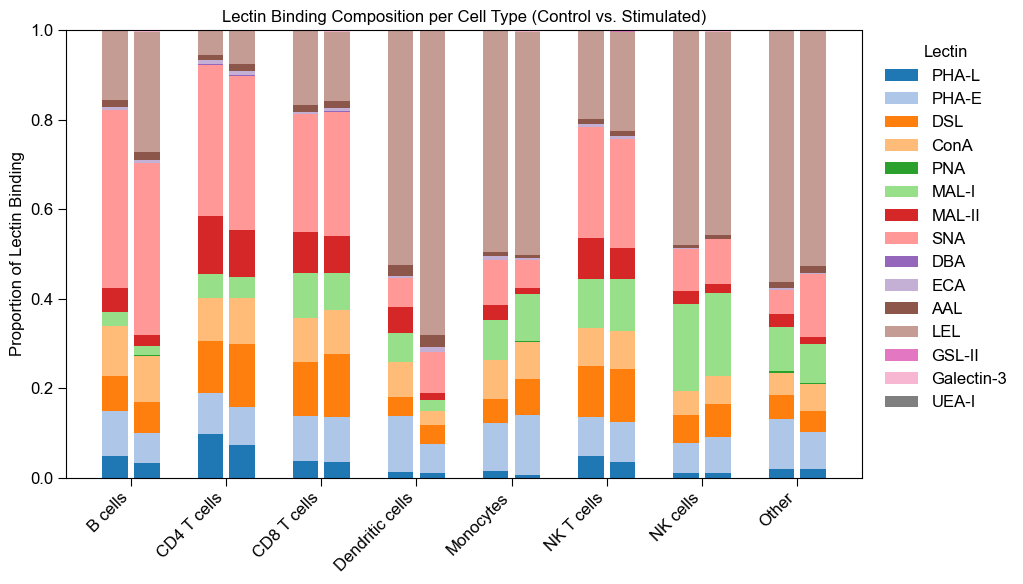

In [229]:
# Ensure proportions DataFrame from earlier is available
# Index: (cell_type, condition), Columns: lectins
plot_df = proportions.reset_index()

# Get ordered cell types and lectins
cell_types = plot_df["cell_type"].unique().tolist()
conditions = ["control", "stimulated"]
lectins = [col for col in plot_df.columns if col not in ["cell_type", "condition"]]

# Set bar positions: 2 bars (control + stimulated) per cell type
condition_offset = 1
cell_gap = 3
bar_positions = []
bar_labels = []
position_lookup = {}
x = 0
for ct in cell_types:
    for i, cond in enumerate(conditions):
        pos = x + i * condition_offset
        bar_positions.append(pos)
        bar_labels.append(f"{ct}\n{cond}")
        position_lookup[(ct, cond)] = pos
    x += cell_gap

# Get values per lectin
stack_data = []
for lectin in lectins:
    values = []
    for ct in cell_types:
        for cond in conditions:
            row = plot_df[(plot_df["cell_type"] == ct) & (plot_df["condition"] == cond)]
            values.append(row[lectin].values[0] if not row.empty else 0)
    stack_data.append(values)

# Plotting
fig, ax = plt.subplots(figsize=(len(cell_types) * 0.8 + 4, 6))
bottom = np.zeros(len(bar_positions))
colors = plt.cm.tab20.colors

for i, (lectin, values) in enumerate(zip(lectins, stack_data)):
    ax.bar(bar_positions, values, bottom=bottom, label=lectin, color=colors[i % len(colors)])
    bottom += values

# Center ticks between control/stimulated
center_positions = [position_lookup[(ct, "control")] + condition_offset / 2 for ct in cell_types]
ax.set_xticks(center_positions)
ax.set_xticklabels(cell_types, rotation=45, ha="right")

ax.set_ylabel("Proportion of Lectin Binding")
ax.set_title("Lectin Binding Composition per Cell Type (Control vs. Stimulated)")
ax.legend(title="Lectin", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

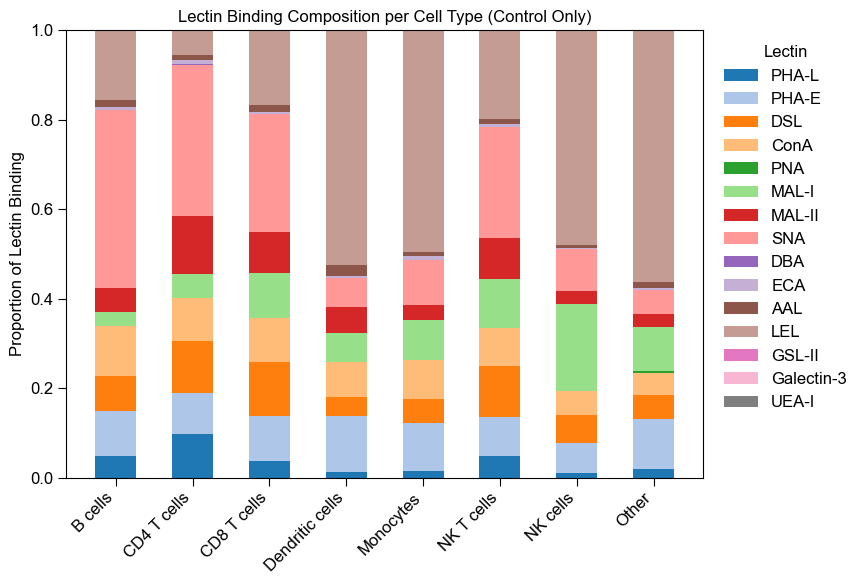

In [230]:
# Filter to only 'control' condition
plot_df = plot_df[plot_df["condition"] == "control"].copy()

# Updated condition and layout config
conditions = ["control"]
cell_types = plot_df["cell_type"].unique().tolist()
lectins = [col for col in plot_df.columns if col not in ["cell_type", "condition"]]

# Set bar positions: 1 bar per cell type
cell_gap = 1.5
bar_positions = []
position_lookup = {}
x = 0
for ct in cell_types:
    pos = x
    bar_positions.append(pos)
    position_lookup[ct] = pos
    x += cell_gap

# Get values per lectin
stack_data = []
for lectin in lectins:
    values = []
    for ct in cell_types:
        row = plot_df[(plot_df["cell_type"] == ct)]
        values.append(row[lectin].values[0] if not row.empty else 0)
    stack_data.append(values)

# Plotting
fig, ax = plt.subplots(figsize=(len(cell_types) * 0.6 + 4, 6))
bottom = np.zeros(len(bar_positions))
colors = plt.cm.tab20.colors

for i, (lectin, values) in enumerate(zip(lectins, stack_data)):
    ax.bar(bar_positions, values, bottom=bottom, label=lectin, color=colors[i % len(colors)])
    bottom += values

ax.set_xticks(bar_positions)
ax.set_xticklabels(cell_types, rotation=45, ha='right')

ax.set_ylabel("Proportion of Lectin Binding")
ax.set_ylim(0, 1.0)
ax.set_title("Lectin Binding Composition per Cell Type (Control Only)")
ax.legend(title="Lectin", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

for main cell type, check protein-specific lectin binding proportion and change between control and stimulated, e.g. CD45

In [25]:
df_pla_all = pd.concat([ctrl_target, cona_target], axis=1)
df_pla_all = df_pla_all.T
df_pla_all = df_pla_all.loc[common_cells]
df_pla_all = df_pla_all[~df_pla_all.index.duplicated(keep='first')]

In [34]:
clr_pla_all = df_pla_all.T.apply(clr_function,axis=0)
#add it into adata
adata.obsm['pla'] = clr_pla_all.T

In [ ]:
for pla in adata.obsm["pla"].columns:
    new_key = f"PLA_{pla}"
    # Add to .obs with the prefixed name
    adata.obs[new_key] = adata.obsm["pla"][pla]

/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_5556/2584325766.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cd45["cell_type"] = adata.obs.loc[df_cd45.index, "main_annotation"]
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_5556/2584325766.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cd45["condition"] = adata.obs.loc[df_cd45.index, "condition"]


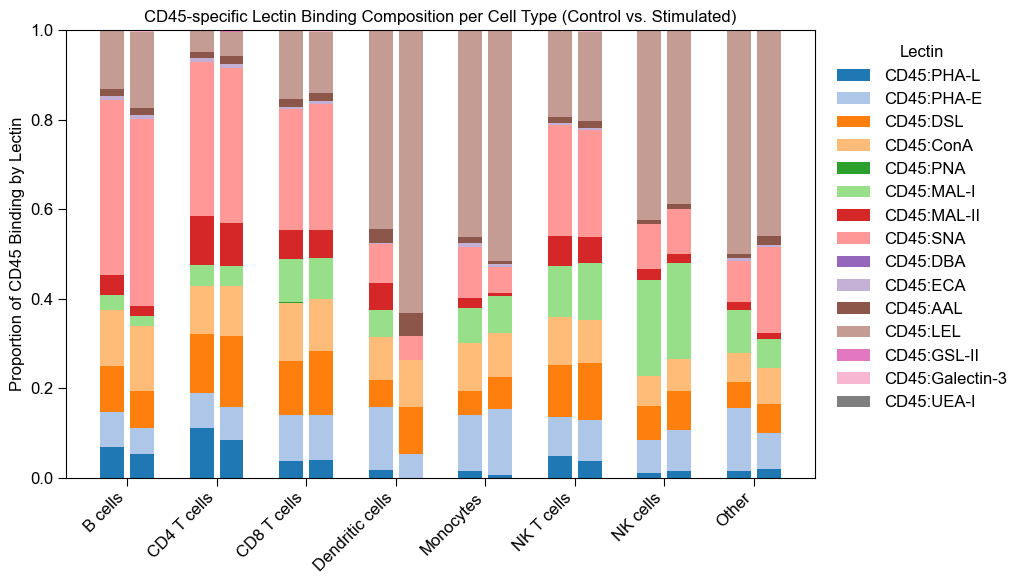

In [204]:
# Step 1: Filter only CD45-specific PLA pairs
df_cd45 = df_pla_all[[col for col in df_pla_all.columns if col.startswith("CD45:") and "free_oligo" not in col]]

# Step 2: Add cell type and condition info
df_cd45["cell_type"] = adata.obs.loc[df_cd45.index, "main_annotation"]
df_cd45["condition"] = adata.obs.loc[df_cd45.index, "condition"]

# Step 3: Group by cell_type and condition, and sum values
grouped = df_cd45.groupby(["cell_type", "condition"]).sum()

# Step 4: Normalize each group to get lectin binding **proportions**
proportions = grouped.div(grouped.sum(axis=1), axis=0)

# Step 5: Reset index for plotting
plot_df = proportions.reset_index()

# Extract info
cell_types = plot_df["cell_type"].unique().tolist()
conditions = ["control", "stimulated"]
plas = [col for col in df_cd45.columns if col.startswith("CD45:") and "free_oligo" not in col]


# Create a mapping from full PLA to lectin
lectin_map = {col: col.split(":")[1] for col in df_cd45.columns if ":" in col}

# Step 6: Bar positions
condition_offset = 1
cell_gap = 3
bar_positions = []
position_lookup = {}
x = 0
for ct in cell_types:
    for i, cond in enumerate(conditions):
        pos = x + i * condition_offset
        bar_positions.append(pos)
        position_lookup[(ct, cond)] = pos
    x += cell_gap

# Step 7: Prepare stacking data per lectin
# Prepare stacking data per full PLA (e.g., CD45:PHA-L)
stack_data = {}
for pla in plas:
    values = []
    for ct in cell_types:
        for cond in conditions:
            match = plot_df[(plot_df["cell_type"] == ct) & (plot_df["condition"] == cond)]
            value = match[pla].values[0] if (not match.empty and pla in match.columns) else 0
            values.append(value)
    stack_data[pla] = values

# Step 8: Plot stacked bar chart
fig, ax = plt.subplots(figsize=(len(cell_types) * 0.8 + 4, 6))
bottom = np.zeros(len(bar_positions))
colors = plt.cm.tab20.colors

for i, (lectin, values) in enumerate(stack_data.items()):
    ax.bar(bar_positions, values, bottom=bottom, label=lectin, color=colors[i % len(colors)])
    bottom += values

# One tick per cell type
center_positions = [position_lookup[(ct, "control")] + condition_offset / 2 for ct in cell_types]
ax.set_xticks(center_positions)
ax.set_xticklabels(cell_types, rotation=45, ha='right')

ax.set_ylabel("Proportion of CD45 Binding by Lectin")
ax.set_title("CD45-specific Lectin Binding Composition per Cell Type (Control vs. Stimulated)")
ax.legend(title="Lectin", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

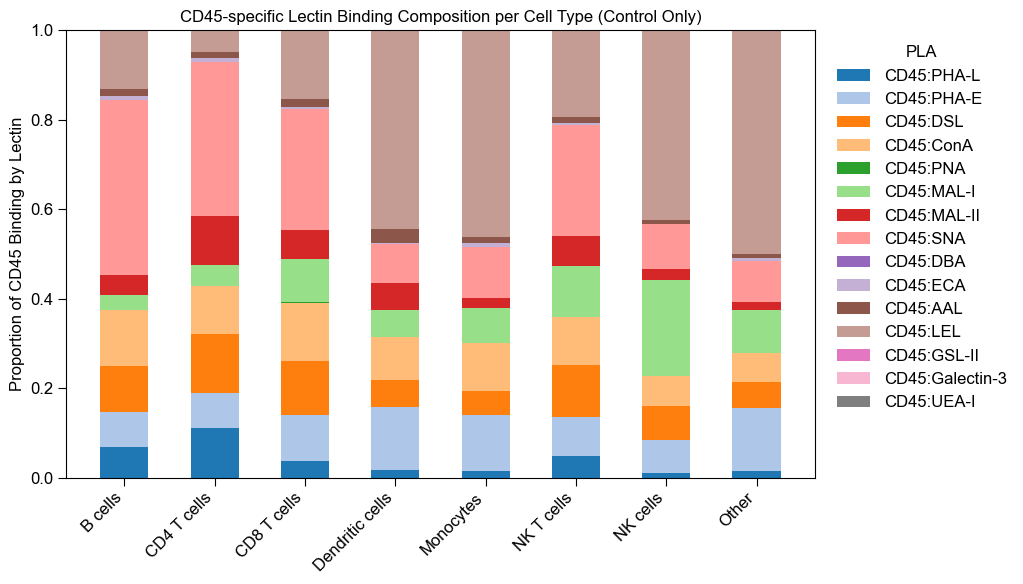

In [221]:
# Step 1: Filter only CD45-specific PLA pairs (already done)
df_cd45 = df_pla_all[[col for col in df_pla_all.columns if col.startswith("CD45:") and "free_oligo" not in col]].copy()

# Step 2: Add cell type and condition info
df_cd45["cell_type"] = adata.obs.loc[df_cd45.index, "main_annotation"]
df_cd45["condition"] = adata.obs.loc[df_cd45.index, "condition"]

# Step 3: Group by cell_type and condition, and sum values
grouped = df_cd45.groupby(["cell_type", "condition"]).sum()

# Step 4: Normalize each group to get lectin binding **proportions**
proportions = grouped.div(grouped.sum(axis=1), axis=0)

# Step 5: Reset index for plotting
plot_df = proportions.reset_index()

# ✅ Filter only control condition
plot_df = plot_df[plot_df["condition"] == "control"]

# Extract info
cell_types = plot_df["cell_type"].unique().tolist()
plas = [col for col in df_cd45.columns if col.startswith("CD45:") and "free_oligo" not in col]

# Step 6: Bar positions: one bar per cell type
cell_gap = 1.5
bar_positions = []
position_lookup = {}
x = 0
for ct in cell_types:
    pos = x
    bar_positions.append(pos)
    position_lookup[ct] = pos
    x += cell_gap

# Step 7: Prepare stacking data per full PLA
stack_data = {}
for pla in plas:
    values = []
    for ct in cell_types:
        match = plot_df[(plot_df["cell_type"] == ct)]
        value = match[pla].values[0] if (not match.empty and pla in match.columns) else 0
        values.append(value)
    stack_data[pla] = values

# Step 8: Plot
fig, ax = plt.subplots(figsize=(len(cell_types) * 0.8 + 4, 6))
bottom = np.zeros(len(bar_positions))
colors = plt.cm.tab20.colors

for i, (pla, values) in enumerate(stack_data.items()):
    ax.bar(bar_positions, values, bottom=bottom, label=pla, color=colors[i % len(colors)])
    bottom += values

ax.set_xticks(bar_positions)
ax.set_xticklabels(cell_types, rotation=45, ha='right')

ax.set_ylabel("Proportion of CD45 Binding by Lectin")
ax.set_title("CD45-specific Lectin Binding Composition per Cell Type (Control Only)")
ax.legend(title="PLA", bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

check for lectin binding change, which protein contribute most? set a threshold for protein abundance

In [66]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from matplotlib.colors import TwoSlopeNorm

def high_mode_mean(values):
    """Return mean of the higher component in a 2-component GMM."""
    values = np.array(values).reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=0).fit(values)
    means = gmm.means_.flatten()
    return max(means)

def plot_per_celltype_heatmaps_scaled(
    adata,
    feature_prefix="ADT_",
    celltypes=None,
    groupby="manual_annotation",
    condition_col="condition",
    figsize=(2.5, 6),
    cmap="vlag",
    save_dir=None,
    scale="zscore"  # or "center", "robust", or None
):
    """
    Per-cell type heatmap of LDT features (e.g., lectin/protein binding), scaled across conditions.
    
    If proteins like CD44 or CD45 show bimodal distribution, this function uses
    a GMM to extract the high-expression mode mean for the stimulated condition.
    """

    # Make save directory if needed
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # Step 1: detect features
    feature_cols = [col for col in adata.obs.columns if col.startswith(feature_prefix)]

    # Step 2: get all relevant cell types
    if celltypes is None:
        celltypes = adata.obs[groupby].unique().tolist()

    # Step 3: define bimodal proteins (adjust names as needed)
    special_proteins = [f"{feature_prefix}CD44", f"{feature_prefix}CD45"]

    for celltype in celltypes:
        adata_subset = adata[adata.obs[groupby] == celltype]
        if adata_subset.n_obs == 0:
            continue

        # Step 4: compute summary (mean or high-mode for bimodal in stimulated)
        rows = []
        for condition in adata_subset.obs[condition_col].unique():
            subset = adata_subset.obs[adata_subset.obs[condition_col] == condition]
            row = {}
            for col in feature_cols:
                if condition.lower() == "stimulated" and col in special_proteins:
                    try:
                        row[col] = high_mode_mean(subset[col])
                    except:
                        row[col] = np.nan
                else:
                    row[col] = subset[col].median()
            rows.append(pd.Series(row, name=condition))
        df = pd.DataFrame(rows).T

        # Step 5: scale across conditions (row-wise)
        if scale == "zscore":
            df_scaled = df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
        elif scale == "center":
            df_scaled = df.sub(df.mean(axis=1), axis=0)
        elif scale == "robust":
            df_scaled = df.apply(lambda x: (x - x.median()) / (x.quantile(0.75) - x.quantile(0.25)), axis=1)
        else:
            df_scaled = df

        # Step 6: plot
        plt.figure(figsize=figsize)
        norm = TwoSlopeNorm(vcenter=0)
        sns.heatmap(df_scaled, cmap=cmap, norm=norm, cbar=True, fmt=".2f")

        plt.title(celltype)
        plt.xticks(rotation=90, ha='center')
        plt.tight_layout()

        # Save or show
        if save_dir and feature_prefix == "ADT_":
            filename = os.path.join(save_dir, f"{celltype.replace(' ', '_')}_protein_change.svg")
            plt.ylabel("Protein")
            plt.savefig(filename, format="svg", bbox_inches='tight', pad_inches=0)
            plt.close()
            print(f"Saved: {filename}")
        elif save_dir and feature_prefix == "LDT_":
            filename = os.path.join(save_dir, f"{celltype.replace(' ', '_')}_Lectin_change.svg")
            plt.ylabel("Lectin")
            plt.savefig(filename, format="svg", bbox_inches='tight', pad_inches=0)
            plt.close()
            print(f"Saved: {filename}")
        else:
            plt.show()

In [228]:
#look in to T cells and NK cells specifically, major populations in our pbmc
cell_types_of_interest = [
    "CD4+ Naive T cells", "CD4+ Central Memory", "CD4+ Effector Memory",
    "CD8+ Naive T cells", "CD8+ Central Memory", "CD8+ Effector Memory", "CD8+ Effector Memory RA",
    "Treg", "NK cells_CD56+CD16+", "NK cells_CD56+CD16-"
]

plot_per_celltype_heatmaps_scaled(
    adata,
    feature_prefix="ADT_",
    celltypes=cell_types_of_interest,
    groupby="manual_annotation",
    condition_col="condition",
    scale='center',  # highlight change
    figsize=(3,10),
    cmap="RdBu_r",
    save_dir="/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs"
)

Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD4+_Naive_T_cells_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD4+_Central_Memory_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD4+_Effector_Memory_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD8+_Naive_T_cells_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD8+_Central_Memory_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD8+_Effector_Memory_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD8+_Effector_Memory_RA_protein_change.pdf
Saved: /Users/junjie/De

In [73]:
#look in to T cells and NK cells specifically, major populations in our pbmc
cell_types_of_interest = [ "CD4+ Effector Memory", "CD8+ Effector Memory"]

plot_per_celltype_heatmaps_scaled(
    adata,
    feature_prefix="ADT_",
    celltypes=cell_types_of_interest,
    groupby="manual_annotation_reclustered",
    condition_col="condition",
    scale='center',  # highlight change
    figsize=(3,10),
    cmap="RdBu_r",
    save_dir = '/Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/'
)

Saved: /Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/CD4+_Effector_Memory_protein_change.svg
Saved: /Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/CD8+_Effector_Memory_protein_change.svg


In [74]:
#look in to T cells and NK cells specifically, major populations in our pbmc
cell_types_of_interest = [ "CD4+ Effector Memory", "CD8+ Effector Memory"]

plot_per_celltype_heatmaps_scaled(
    adata,
    feature_prefix="LDT_",
    celltypes=cell_types_of_interest,
    groupby="manual_annotation_reclustered",
    condition_col="condition",
    scale='center',  # highlight change
    figsize=(3,10),
    cmap="RdBu_r",
    save_dir = '/Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/'
)

Saved: /Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/CD4+_Effector_Memory_Lectin_change.svg
Saved: /Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/CD8+_Effector_Memory_Lectin_change.svg


In [78]:
# Step 1: Filter target cell type
target_celltype = "CD8+ Effector Memory"
subset_cells = adata.obs[adata.obs["manual_annotation_reclustered"] == target_celltype]
subset_barcodes = subset_cells.index

# Step 2: Subset PLA matrix
pla_data = df_pla_all.loc[subset_barcodes]
obs_subset = adata.obs.loc[subset_barcodes]

# Step 3: Extract all PLA proteins and lectins
all_pairs = pla_data.columns
# Now split into protein and lectin
protein_lectin = pd.DataFrame(
    [col.split(":") for col in pla_data.columns], columns=["protein", "lectin"]
)
pla_data.columns = pd.MultiIndex.from_frame(protein_lectin)
pla_data["condition"] = obs_subset["condition"]

# Step 4: For each condition, calculate:
# (CD45:LEL) / sum(CD45:*), for each protein

results = []
for cond in ["control", "stimulated"]:
    df_cond = pla_data[pla_data["condition"] == cond].drop(columns="condition")

    # sum across cells
    avg_pla = df_cond.groupby(level=0, axis=1).sum()  # protein → sum over all lectins
    avg_lel = df_cond.xs("LEL", level=1, axis=1)      # protein → LEL only

    # normalize LEL by total PLA per protein
    prop = avg_lel.div(avg_pla + 1e-10)  # avoid divide-by-zero
    prop["condition"] = cond
    results.append(prop)

# Step 5: Concatenate and compute change
df_props = pd.concat(results)
df_props = df_props.groupby("condition").mean().T  # now: rows=protein, columns=condition
df_props["change"] = df_props["stimulated"] - df_props["control"]


# Step 6: Filter by ADT expression in both conditions
# Get ADT columns
adt_cols = [col for col in adata.obs.columns if col.startswith("ADT_")]
adt_clean = [col.replace("ADT_", "") for col in adt_cols]

# Subset ADT by barcodes and split by condition
adt_data = adata.obs.loc[subset_barcodes, adt_cols]
cond_series = obs_subset["condition"]

# Calculate median expression per protein per condition
control_expr = adt_data[cond_series == "control"].median()
stim_expr = adt_data[cond_series == "stimulated"].median()

# Rename indices to match protein names
control_expr.index = [col.replace("ADT_", "") for col in control_expr.index]
stim_expr.index = [col.replace("ADT_", "") for col in stim_expr.index]

# Filter: both medians must be > threshold
expression_threshold = 0
expressed_proteins = control_expr[(control_expr > expression_threshold) & 
                                  (stim_expr > expression_threshold)].index

# Subset PLA proportion data
df_props = df_props.loc[df_props.index.isin(expressed_proteins)]


df_props = df_props.loc[df_props.index.isin(expressed_proteins)]

# Step 7: Sort by change
df_props = df_props.sort_values("change", ascending=False)

# Step 8: Show result
print(df_props[["control", "stimulated", "change"]])


condition   control  stimulated    change
protein                                  
ICAM-1     0.180897    0.275925  0.095028
HLADR      0.167432    0.253733  0.086301
CD47       0.094850    0.150681  0.055831
CD147      0.149170    0.200775  0.051605
CD49e      0.108595    0.155839  0.047244
CD44       0.122068    0.168127  0.046059
CD29       0.113470    0.152545  0.039076
CD48       0.126152    0.156792  0.030640
CD11b      0.138108    0.167690  0.029581
CD5        0.079906    0.108898  0.028992
CD45       0.101888    0.130628  0.028740
CD7        0.099697    0.121925  0.022228
CD2        0.112561    0.131909  0.019349
CD62L      0.062639    0.078731  0.016092
CD3        0.100017    0.115791  0.015774
CD8        0.150671    0.160630  0.009959
CD27       0.063530    0.070390  0.006860
CXCR4      0.078535    0.069010 -0.009525
CD11a      0.102841    0.093257 -0.009584


/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_30518/3284639741.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cond = pla_data[pla_data["condition"] == cond].drop(columns="condition")
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_30518/3284639741.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_pla = df_cond.groupby(level=0, axis=1).sum()  # protein → sum over all lectins
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_30518/3284639741.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_cond = pla_data[pla_data["condition"] == cond].drop(columns="condition")
/var/folders/3m/mdf183dx4b79fpz1v51zf93w0000gn/T/ipykernel_30518/3284639741.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis 

In [70]:
save_dir = '/Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/'

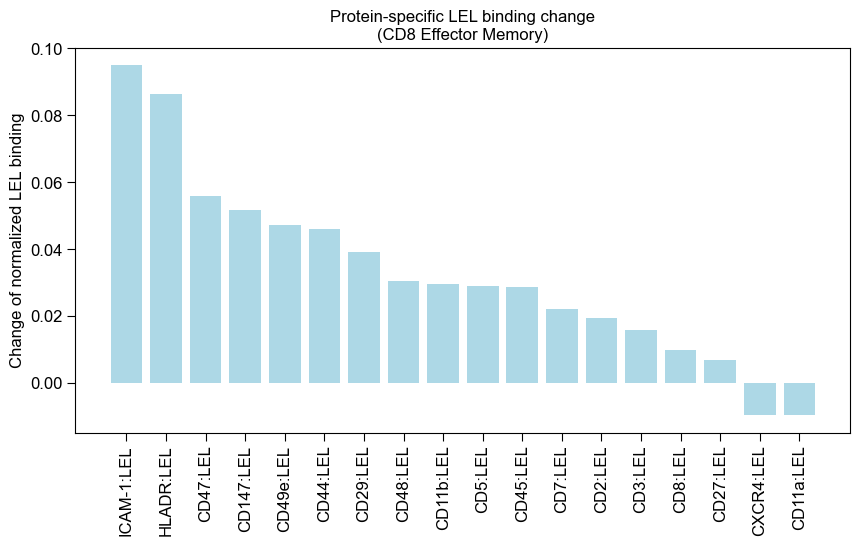

In [83]:
df_props_plot = df_props.loc[~df_props.index.str.contains('CD62L'),:].copy()
df_props_plot["label"] = df_props_plot.index + ":LEL"
df_props_plot = df_props_plot.sort_values("change", ascending=False)

# Step 2: Plot
plt.figure(figsize=(10, 5))
plt.bar(df_props_plot["label"], df_props_plot["change"], color="lightblue")

# Step 3: Style
plt.xticks(rotation=90, ha='center')
plt.ylabel("Change of normalized LEL binding")
plt.title("Protein-specific LEL binding change\n(CD8 Effector Memory)")
plt.savefig(save_dir + "CD8TEM_LEL_stimulation.svg", format="svg", bbox_inches='tight', pad_inches=0)

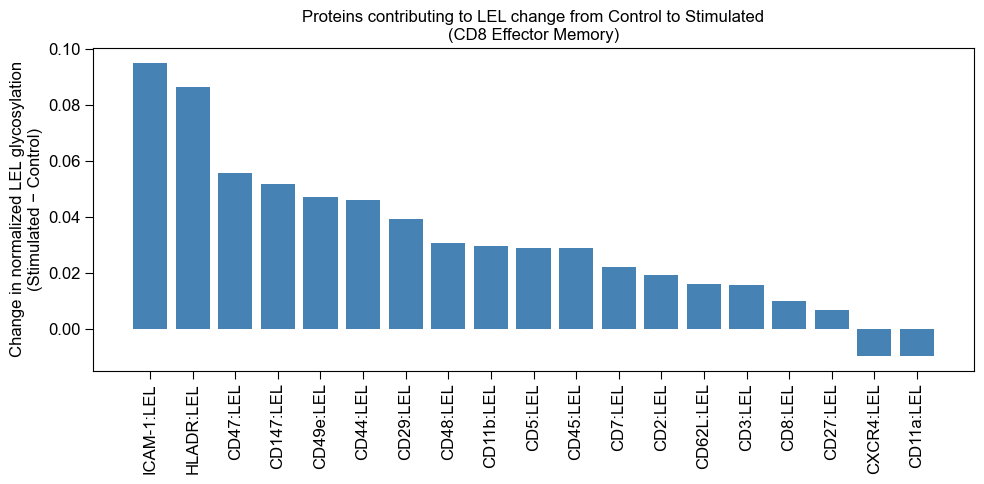

In [80]:
df_props_plot = df_props.copy()
df_props_plot["label"] = df_props_plot.index + ":LEL"
df_props_plot = df_props_plot.sort_values("change", ascending=False)

# Step 2: Plot
plt.figure(figsize=(10, 5))
plt.bar(df_props_plot["label"], df_props_plot["change"], color="steelblue")

# Step 3: Style
plt.xticks(rotation=90, ha='center')
plt.ylabel("Change in normalized LEL glycosylation\n(Stimulated − Control)")
plt.title("Proteins contributing to LEL change from Control to Stimulated\n(CD8 Effector Memory)")
plt.tight_layout()
plt.show()

In [151]:
# Subset only CD4+ Effector Memory T cells
subset = adata[adata.obs["manual_annotation"] == "CD8+ Effector Memory"].copy()

In [152]:
sc.pp.normalize_total(subset, target_sum=1e4, layer='counts')
sc.pp.log1p(subset, layer='counts')

In [153]:
# Set group labels
subset.obs["group"] = subset.obs["condition"]

sc.tl.rank_genes_groups(
    subset,
    groupby="group",
    groups=["stimulated"],
    reference="control",
    method="wilcoxon",
    use_raw=False,
    layer="counts",  # use the normalized & log1p layer
    pts=True
)

# Extract results
de_result = sc.get.rank_genes_groups_df(subset, group="stimulated")

In [154]:
de_glyco = de_result[de_result["names"].isin(glyco_genes)].copy()

In [155]:
de_glyco

names    scores  logfoldchanges         pvals     pvals_adj  \
92          EXT1  7.223653        1.296703  5.060931e-13  1.204984e-11   
183       MAN1A1  4.758960        0.713335  1.945930e-06  2.330456e-05   
242         FUT8  3.752218        0.568733  1.752766e-04  1.527465e-03   
310        MGAT5  2.895448        0.432363  3.786177e-03  2.611156e-02   
368      ST3GAL4  2.433212        0.858724  1.496553e-02  8.527368e-02   
371      B4GALT5  2.405024        0.362336  1.617141e-02  9.136388e-02   
579        GCNT1  1.314117        0.323933  1.888068e-01  6.416543e-01   
583       GALNT6  1.306234        0.612448  1.914728e-01  6.463219e-01   
627      ST8SIA6  1.122438        0.469334  2.616764e-01  8.171004e-01   
767        XYLT1  0.716129        0.076815  4.739117e-01  1.000000e+00   
781       B3GNT5  0.683201        0.683197  4.944797e-01  1.000000e+00   
1022       TMTC2  0.324638       -0.023078  7.454552e-01  1.000000e+00   
1071     ST3GAL3  0.280036       -0.011981  7.794501e-01  1.000000e+00   
1260       FUT10  0.164689       -0.066694  8.691890e-01  1.000000e+00   
1581        EXT2  0.074487       -0.062490  9.406232e-01  1.000000e+00   
1751     B3GALT5  0.042207       20.746439  9.663334e-01  1.000000e+00   
1829     B4GALT6  0.001497       -0.048615  9.988058e-01  1.000000e+00   
2039  ST6GALNAC1  0.000000        0.000000  1.000000e+00  1.000000e+00   
2226     ST8SIA5 -0.041908       -1.291692  9.665720e-01  1.000000e+00   
2398  ST6GALNAC3 -0.083217       -0.596072  9.336786e-01  1.000000e+00   
2525       TMTC4 -0.087159       -0.140097  9.305453e-01  1.000000e+00   
2701       GCNT3 -0.168231      -23.053417  8.664016e-01  1.000000e+00   
2737       GCNT4 -0.196020       -0.147684  8.445945e-01  1.000000e+00   
3324     ST8SIA4 -1.056283       -0.159118  2.908390e-01  8.796765e-01   
3390       GCNT2 -1.259736       -0.974781  2.077645e-01  6.885318e-01   
3411     ST6GAL1 -1.346596       -0.186889  1.781104e-01  6.145066e-01   
3621      GALNT3 -2.165799       -0.735628  3.032657e-02  1.554942e-01   
3895     ST8SIA1 -6.132596       -1.629126  8.645623e-10  1.459177e-08   

      pct_nz_group  
92        0.456702  
183       0.505338  
242       0.518387  
310       0.506524  
368       0.144721  
371       0.399763  
579       0.181495  
583       0.092527  
627       0.166074  
767       0.314353  
781       0.056940  
1022      0.243179  
1071      0.326216  
1260      0.120996  
1581      0.213523  
1751      0.001186  
1829      0.018980  
2039      0.000000  
2226      0.001186  
2398      0.005931  
2525      0.134045  
2701      0.000000  
2737      0.058126  
3324      0.429419  
3390      0.042705  
3411      0.479241  
3621      0.135231  
3895      0.124555

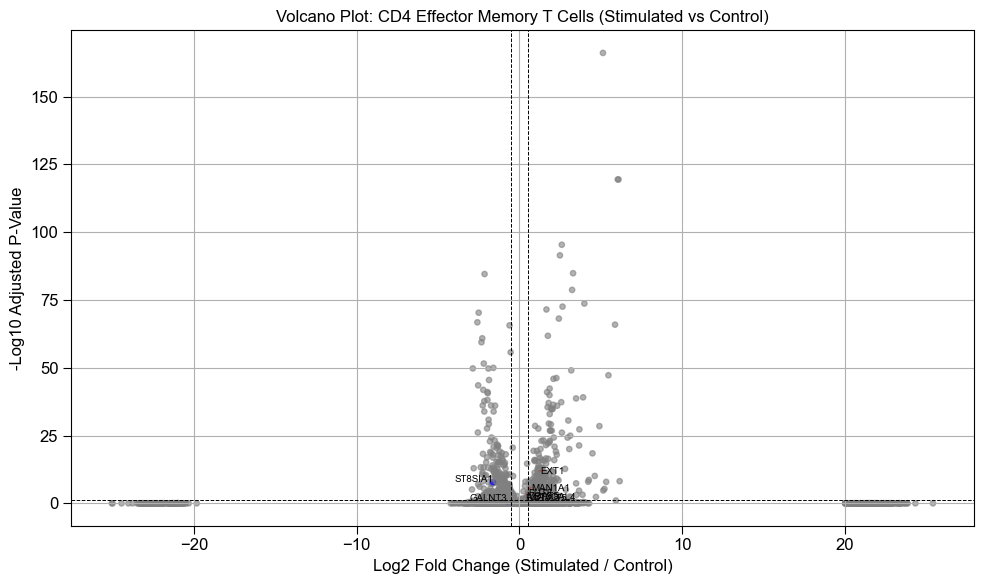

In [158]:
glyco_genes = sorted(set([
    "DPAGT1", "ALG1", "ALG2", "ALG3", "ALG5", "ALG6", "ALG8", "ALG9", "ALG10",
    "MAN1B1", "MAN1A1", "MAN1A2", "MAN2A1", "MAN2A2", "MGAT1", "MGAT2", "MGAT3", 
    "MGAT4A", "MGAT4B", "MGAT5", "MGAT5B", "GALNT1", "GALNT2", "GALNT3", "GALNT4", 
    "GALNT5", "GALNT6", "GALNT7", "GALNT10", "GALNT11", "GALNT12", "C1GALT1", 
    "C1GALT1C1", "GCNT1", "GCNT2", "GCNT3", "GCNT4", "GCNT7", "B3GNT6", "B3GNT3", 
    "B3GNT7", "ST3GAL1", "ST3GAL2", "ST3GAL3", "ST3GAL4", "ST3GAL5", "ST3GAL6", 
    "ST6GAL1", "ST6GAL2", "ST6GALNAC1", "ST6GALNAC2", "ST6GALNAC3", "ST6GALNAC4", 
    "ST6GALNAC5", "ST6GALNAC6", "ST8SIA1", "ST8SIA2", "ST8SIA3", "ST8SIA4", 
    "ST8SIA5", "ST8SIA6", "FUT1", "FUT2", "FUT3", "FUT4", "FUT5", "FUT6", "FUT7", 
    "FUT8", "FUT9", "FUT10", "FUT11", "B4GALT1", "B4GALT2", "B4GALT3", "B4GALT4", 
    "B4GALT5", "B4GALT6", "B3GALT1", "B3GALT2", "B3GALT3", "B3GALT4", "B3GALT5", 
    "B3GNT1", "B3GNT2", "B3GNT3", "B3GNT4", "B3GNT5", "B3GNT6", "B3GNT7", "B3GNT8", 
    "B3GNT9", "EDEM1", "EDEM2", "EDEM3", "UGGT1", "UGGT2", "GANAB", "PRKCSH", 
    "RPN1", "RPN2", "DDOST", "DAD1", "MAGT1", "OST4", "STT3A", "STT3B", "TUSC3", 
    "EXT1", "EXT2", "XYLT1", "XYLT2", "B4GAT1", "POMGNT1", "POMGNT2", "POMT1", 
    "POMT2", "POMK", "TMTC1", "TMTC2", "TMTC3", "TMTC4"
]))

gene_names = [
    "PTPRC",   # CD45
    "CD47",
    "CD48",
    "CD44",
    "CD2",
    "CD3D",    # Representing CD3 complex
    "CD4",
    "CD8A",    # CD8 can be CD8A or CD8B; commonly CD8A used
    "CD5",
    "CD7",
    "CD27",
    "PTPRC",   # CD45RO is an isoform of PTPRC
    "SELL",    # CD62L
    "CCR5",
    "CCR7",
    "IL7R",    # CD127
    "IL2RA",   # CD25
    "CD28",
    "TNFRSF9", # CD137
    "TNFSF5",  # CD154 (CD40L)
    "SLAMF1",  # CD150
    "CD38",
    "PDCD1",   # PD1
    "HAVCR2",  # TIM-3
    "LAG3",
    "CTLA4",
    "CD19",
    "MS4A1",   # CD20
    "NCAM1",   # CD56
    "FCGR3A",  # CD16
    "CD14",
    "ITGAM",   # CD11b
    "ITGAX",   # CD11c
    "HLA-DRA", # HLADR
    "CXCR3",
    "CXCR4",
    "ITGAL",   # CD11a
    "ITGA5",   # CD49e
    "ITGB1",   # CD29
    "ICAM1",   # ICAM-1
    "CD81",
    "BSG"      # CD147
]


# Compute -log10 adjusted p-values
de_result["-log10(padj)"] = -np.log10(de_result["pvals_adj"] + 1e-300)

# Assign color
de_result["color"] = "gray"
is_glyco = de_result["names"].isin(glyco_genes)
is_up = (de_result["logfoldchanges"] > 0) & (de_result["pvals"] < 0.05)
is_down = (de_result["logfoldchanges"] < 0) & (de_result["pvals"] < 0.05)
de_result.loc[is_glyco & is_up, "color"] = "red"
de_result.loc[is_glyco & is_down, "color"] = "blue"

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    de_result["logfoldchanges"],
    de_result["-log10(padj)"],
    c=de_result["color"],
    s=15,
    alpha=0.6
)
for _, row in de_result.loc[is_glyco & (is_up | is_down)].iterrows():
    plt.text(
        row["logfoldchanges"],
        row["-log10(padj)"],
        row["names"],
        fontsize=7,
        ha='right' if row["logfoldchanges"] < 0 else 'left'
    )

# Threshold lines
plt.axhline(-np.log10(0.05), linestyle='--', color='black', linewidth=0.7)
plt.axvline(0.5, linestyle='--', color='black', linewidth=0.7)
plt.axvline(-0.5, linestyle='--', color='black', linewidth=0.7)

# Format
plt.xlabel("Log2 Fold Change (Stimulated / Control)")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot: CD4 Effector Memory T Cells (Stimulated vs Control)")
plt.grid(True)
plt.tight_layout()
plt.show()


check for protein change, which lectin binding contribute most?

In [262]:
plot_per_celltype_heatmaps_scaled(
    adata,
    feature_prefix="ADT_",
    celltypes=cell_types_of_interest,
    groupby="manual_annotation",
    condition_col="condition",
    scale="center",  # CLR-normalized ADT is often already centered, or use None
    figsize=(3, 10),
    cmap="RdBu_r",
    save_dir="/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs"
)

Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD4+_Naive_T_cells_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD4+_Central_Memory_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD4+_Effector_Memory_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD8+_Naive_T_cells_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD8+_Central_Memory_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD8+_Effector_Memory_protein_change.pdf
Saved: /Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20250521/temp_figs/CD8+_Effector_Memory_RA_protein_change.pdf
Saved: /Users/junjie/De

NK cell difference

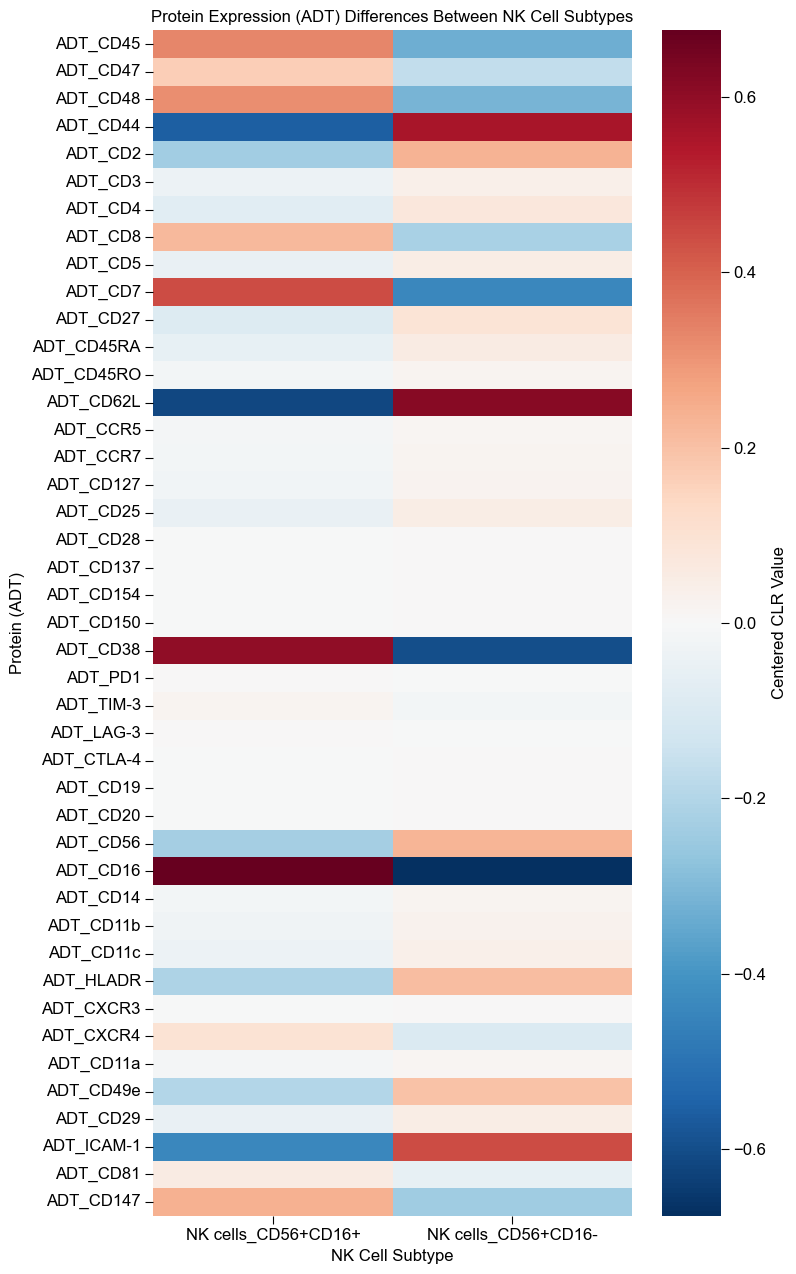

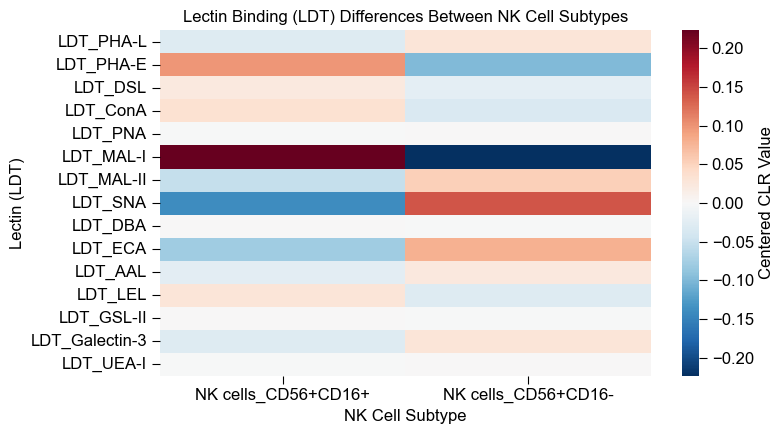

In [335]:
# Step 1: Subset to control NK cells
nk_types = ["NK cells_CD56+CD16+", "NK cells_CD56+CD16-"]
mask = (adata.obs["manual_annotation"].isin(nk_types)) & (adata.obs["condition"] == "control")
adata_nk_ctrl = adata[mask].copy()

# Step 2: Get obs and extract ADT/LDT features
obs = adata_nk_ctrl.obs.copy()
adt_cols = [col for col in obs.columns if col.startswith("ADT_")]
ldt_cols = [col for col in obs.columns if col.startswith("LDT_")]

# Step 3: Compute group-wise means (mean per subtype)
mean_adt = obs.groupby("manual_annotation")[adt_cols].mean().T
mean_ldt = obs.groupby("manual_annotation")[ldt_cols].mean().T

# Step 4: Mean-center (across each feature)
mean_adt_centered = mean_adt.sub(mean_adt.mean(axis=1), axis=0)
mean_ldt_centered = mean_ldt.sub(mean_ldt.mean(axis=1), axis=0)


# Step 5: Plot ADT heatmap
plt.figure(figsize=(8, len(mean_adt_centered) * 0.3))
sns.heatmap(mean_adt_centered, cmap="RdBu_r", center=0, linecolor='gray', cbar_kws={"label": "Centered CLR Value"})
plt.title("Protein Expression (ADT) Differences Between NK Cell Subtypes")
plt.xlabel("NK Cell Subtype")
plt.ylabel("Protein (ADT)")
plt.tight_layout()
plt.show()

# Step 6: Plot LDT heatmap
plt.figure(figsize=(8, len(mean_ldt_centered) * 0.3))
sns.heatmap(mean_ldt_centered, cmap="RdBu_r", center=0, linecolor='gray', cbar_kws={"label": "Centered CLR Value"})
plt.title("Lectin Binding (LDT) Differences Between NK Cell Subtypes")
plt.xlabel("NK Cell Subtype")
plt.ylabel("Lectin (LDT)")
plt.tight_layout()
plt.show()


In [ ]:
import sys
import humanize

for var_name in dir():
    if var_name.startswith("_"): continue
    var = eval(var_name)
    try:
        size = sys.getsizeof(var)
        print(f"{var_name:30} {humanize.naturalsize(size)}")
    except:
        pass

In [367]:
import psutil
mem = psutil.virtual_memory()
print(f"Total: {mem.total / 1e9:.2f} GB")
print(f"Available: {mem.available / 1e9:.2f} GB")
print(f"Used: {mem.used / 1e9:.2f} GB")
print(f"Percent Used: {mem.percent}%")

Total: 17.18 GB
Available: 4.30 GB
Used: 6.55 GB
Percent Used: 75.0%


Correlation between lectin binding; potential competing or coordinating effect between lectin binding 

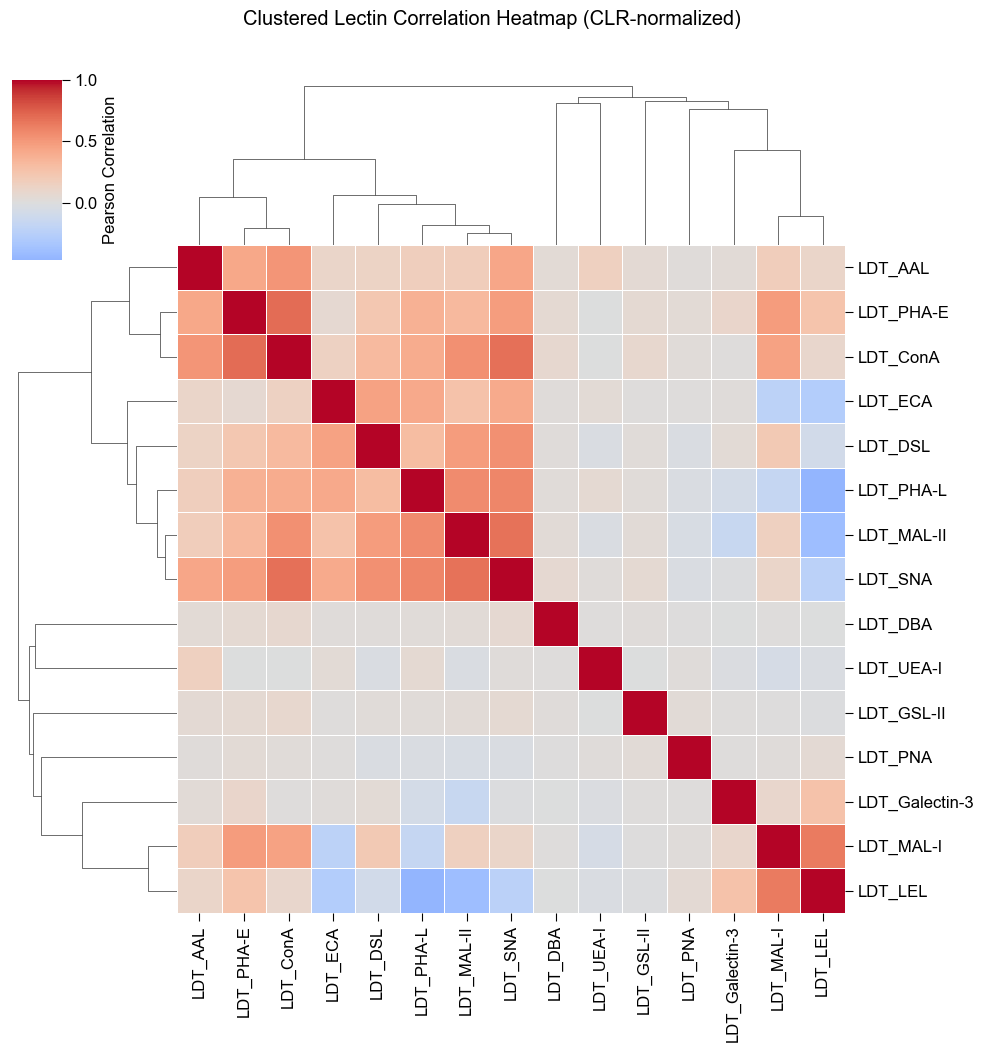

In [338]:
# Step 1: Extract LDT features
ldt_cols = [col for col in adata.obs.columns if col.startswith("LDT_")]
df_lectin_corr = adata.obs[ldt_cols].copy()

# Optional: restrict to one condition or cell type
# df_lectin = df_lectin[adata.obs["condition"] == "control"]

# Step 2: Compute pairwise correlation
lectin_corr = df_lectin_corr.corr(method="pearson")  # or "spearman"

# Step 3: Clustered heatmap
sns.clustermap(
    lectin_corr,
    method="average",  # or "ward", "complete", "single"
    metric="correlation",
    cmap="coolwarm",
    center=0,
    figsize=(10, 10),
    linewidths=0.5,
    cbar_kws={"label": "Pearson Correlation"},
    xticklabels=True,
    yticklabels=True
)

plt.suptitle("Clustered Lectin Correlation Heatmap (CLR-normalized)", y=1.05)
plt.show()


In [341]:
#correlation between protein and lectin
correlation_matrix = clr_protein_all.corrwith(clr_lectin_all, axis=1, method='pearson')

cor_df = pd.DataFrame(index=clr_protein_all.columns, columns=clr_lectin_all.columns, dtype=float)

for p in clr_protein_all.columns:
    for l in clr_lectin_all.columns:
        cor_df.loc[p, l], _ = stats.pearsonr(clr_protein_all[p], clr_lectin_all[l])

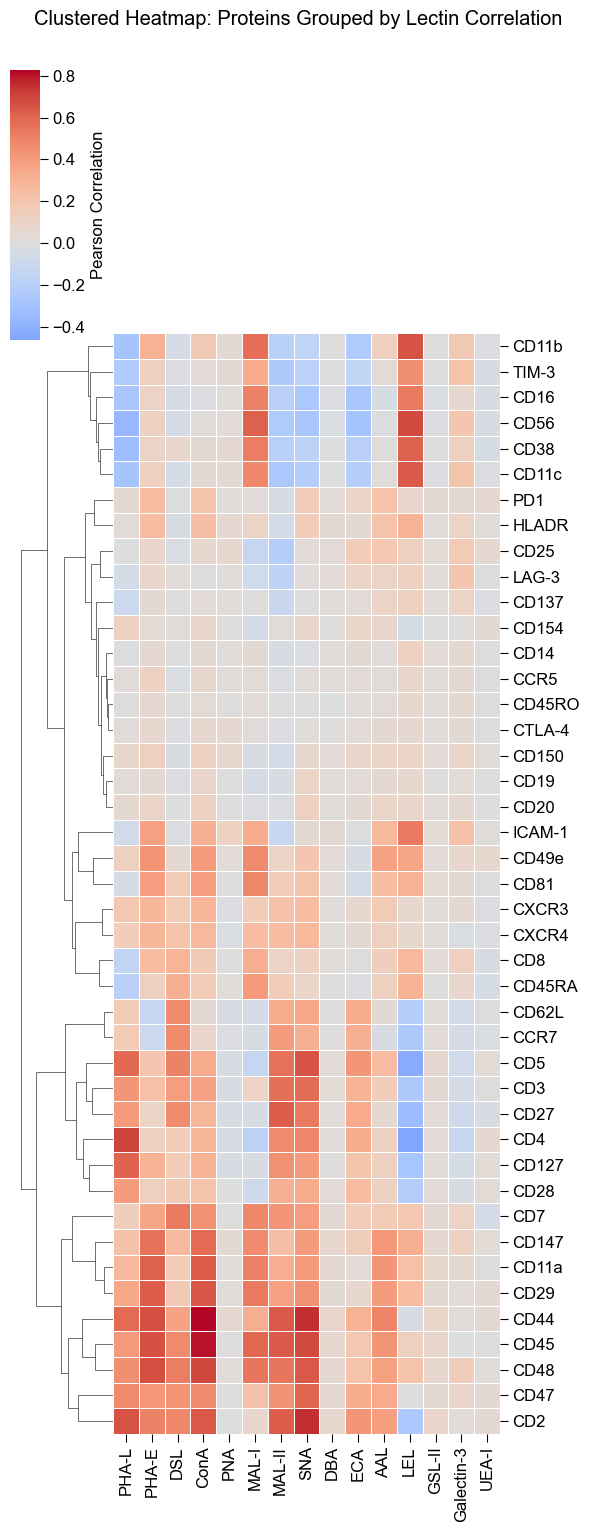

In [342]:
# Clustered heatmap to group proteins based on correlation with lectins
sns.clustermap(cor_df, cmap="coolwarm", center=0, linewidths=0.5, figsize=(6, 15),
               row_cluster=True, col_cluster=False, cbar_kws={'label': 'Pearson Correlation'})
plt.suptitle("Clustered Heatmap: Proteins Grouped by Lectin Correlation", y=1.02)
plt.show()